In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import math
import pandas as pd
from math import exp, floor
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d
import pandas as pd
from random import randint, gauss, random as rand
import time

# Problem description

We have a timeseries of surface height changes at several locations in West Antarctica. We want to use these data to understand local accumulation and densification rates. To do this, we will use a Metropolis algorithm to deconvolve the history of accumulation and the profile of snow depth-density that produce the surface height changes we observe using GPS-interferometric reflectometry. To implement the metropolis algorithm, we need a signal (the measured reflector height) that we can evaluate against a model (viscous deformation model of snow) with degrees of freedom that we can vary, until a modeled solution emerges that best fits our data.

In future iterations of this model, I would like to implement the Hamiltonian Monte Carlo scheme outlined here. The advantage of HMC is we calculate the derivatives of the objective functional (the surface height change) with repect to all the parameters so that we may arrive at a solution more quickly.

## Load data
All the data we need are stored in the matlab file RH.mat. This file includes the surface height reflections for the first 200 days of the 2015 winter. After loading in all the data, we can plot this record and appreciate the signals we are trying to quantify. The height change we measure relative to the GPS antenna is comprised primarily of two signals. The surface rises as snow falls, decreasing the reflector height discontinuously as storm systems moving southward from the amundsen sea coast pass by the GPS. These rising signals are partially offset by the surface falling as the snow densifies between the GPS antenna anchor and the surface via gravitiational settling and snow metamorphism.

In [2]:
khlr = pd.read_csv('../../data/Files/khlr_allRH.csv', delimiter=',',parse_dates= {"date" : [" % year"," Month"," day"]},keep_date_col=True).set_index('date')
lthw = pd.read_csv('../../data/Files/lthw_allRH.csv', delimiter=',',parse_dates= {"date" : [" % year"," Month"," day"]},keep_date_col=True).set_index('date')
uthw = pd.read_csv('../../data/Files/uthw_allRH.csv', delimiter=',',parse_dates= {"date" : [" % year"," Month"," day"]},keep_date_col=True).set_index('date')

In [3]:
tolerence=0.3
reqtracks=40

lthw['RH_median']=abs(lthw[' RH(m)'].values-lthw[' RH(m)'].groupby(pd.Grouper(freq='d')).transform('median').values)
uthw['RH_median']=abs(uthw[' RH(m)'].values-uthw[' RH(m)'].groupby(pd.Grouper(freq='d')).transform('median').values)
khlr['RH_median']=abs(khlr[' RH(m)'].values-khlr[' RH(m)'].groupby(pd.Grouper(freq='d')).transform('median').values)

uthw_median=uthw.groupby(pd.Grouper(freq='d')).median()
lthw_median=lthw.groupby(pd.Grouper(freq='d')).median()
khlr_median=khlr.groupby(pd.Grouper(freq='d')).median()

uthw_median['count']=uthw[(uthw['RH_median']<tolerence)][' RH(m)'].groupby(pd.Grouper(freq='d')).count()
lthw_median['count']=lthw[(lthw['RH_median']<tolerence)][' RH(m)'].groupby(pd.Grouper(freq='d')).count()
khlr_median['count']=khlr[(khlr['RH_median']<tolerence)][' RH(m)'].groupby(pd.Grouper(freq='d')).count()

In [7]:
uthw_median['mean']=uthw[(uthw['RH_median']<tolerence)][' RH(m)'].groupby(pd.Grouper(freq='d')).mean()
lthw_median['mean']=lthw[(lthw['RH_median']<tolerence)][' RH(m)'].groupby(pd.Grouper(freq='d')).mean()
khlr_median['mean']=khlr[(khlr['RH_median']<tolerence)][' RH(m)'].groupby(pd.Grouper(freq='d')).mean()

uthw_median['mean'][(uthw_median['count']<reqtracks)]=np.nan
lthw_median['mean'][(lthw_median['count']<reqtracks)]=np.nan
khlr_median['mean'][(khlr_median['count']<reqtracks)]=np.nan

uthw_median['std']=uthw[(uthw['RH_median']<tolerence)][' RH(m)'].groupby(pd.Grouper(freq='d')).std()
lthw_median['std']=lthw[(lthw['RH_median']<tolerence)][' RH(m)'].groupby(pd.Grouper(freq='d')).std()
khlr_median['std']=khlr[(khlr['RH_median']<tolerence)][' RH(m)'].groupby(pd.Grouper(freq='d')).std()

uthw_median['std'][(uthw_median['count']<reqtracks)]=np.nan
lthw_median['std'][(lthw_median['count']<reqtracks)]=np.nan
khlr_median['std'][(khlr_median['count']<reqtracks)]=np.nan

#uthw_median=uthw.groupby(pd.Grouper(freq='d')).median()
#lthw_median=lthw.groupby(pd.Grouper(freq='d')).median()
#khlr_median=khlr.groupby(pd.Grouper(freq='d')).median()

<ipython-input-7-c7c2d849115f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lthw_median['mean'][(lthw_median['count']<reqtracks)]=np.nan
<ipython-input-7-c7c2d849115f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lthw_median['std'][(lthw_median['count']<reqtracks)]=np.nan


In [8]:
#uthw_median[' RH(m)'][3305]=np.nan
#lthw_median[' RH(m)'][1926]=np.nan

<IPython.core.display.Javascript object>


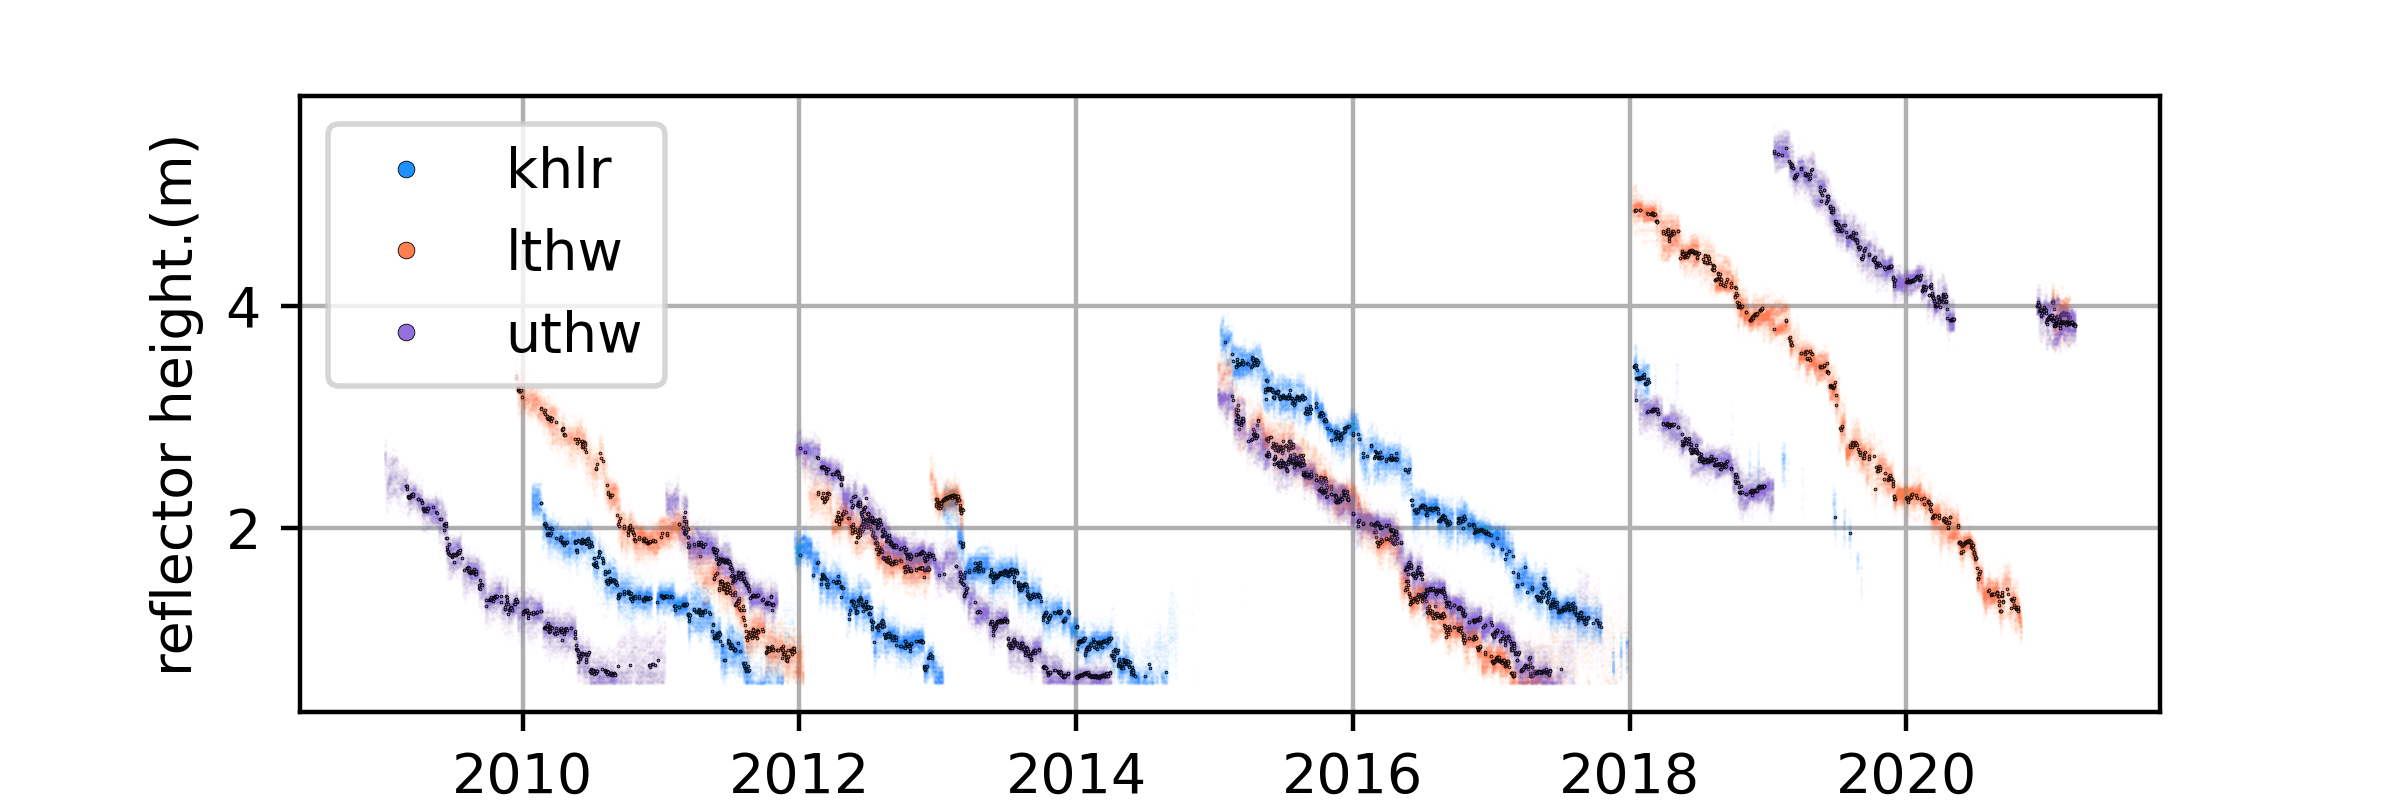

In [10]:
fig,ax=plt.subplots(figsize=(6,2),dpi=300)
ax.plot(khlr[' RH(m)'],'.',markersize=1,markeredgewidth=0.0,alpha=.02,color='dodgerblue')
ax.plot(khlr_median['mean'],'.',markersize=1,markeredgewidth=0.15,markeredgecolor='k',label='khlr',color='dodgerblue')
ax.plot(lthw[' RH(m)'],'.',markersize=1,markeredgewidth=0.0,alpha=.02,color='coral')
ax.plot(lthw_median['mean'],'.',markersize=1,markeredgewidth=0.15,markeredgecolor='k',label='lthw',color='coral')
ax.plot(uthw[' RH(m)'],'.',markersize=1,markeredgewidth=0.0,alpha=.02,color='mediumpurple')
ax.plot(uthw_median['mean'],'.',markersize=1,markeredgewidth=0.15,markeredgecolor='k',label='uthw',color='mediumpurple')

lgnd = ax.legend()

#change the marker size manually for both lines
lgnd.legendHandles[0]._legmarker.set_markersize(6)
lgnd.legendHandles[1]._legmarker.set_markersize(6)
lgnd.legendHandles[2]._legmarker.set_markersize(6)
lgnd.legendHandles[0]._legmarker.set_alpha(1)
lgnd.legendHandles[1]._legmarker.set_alpha(1)
lgnd.legendHandles[2]._legmarker.set_alpha(1)

ax.set_ylabel('reflector height.(m)')
ax.grid()



<IPython.core.display.Javascript object>


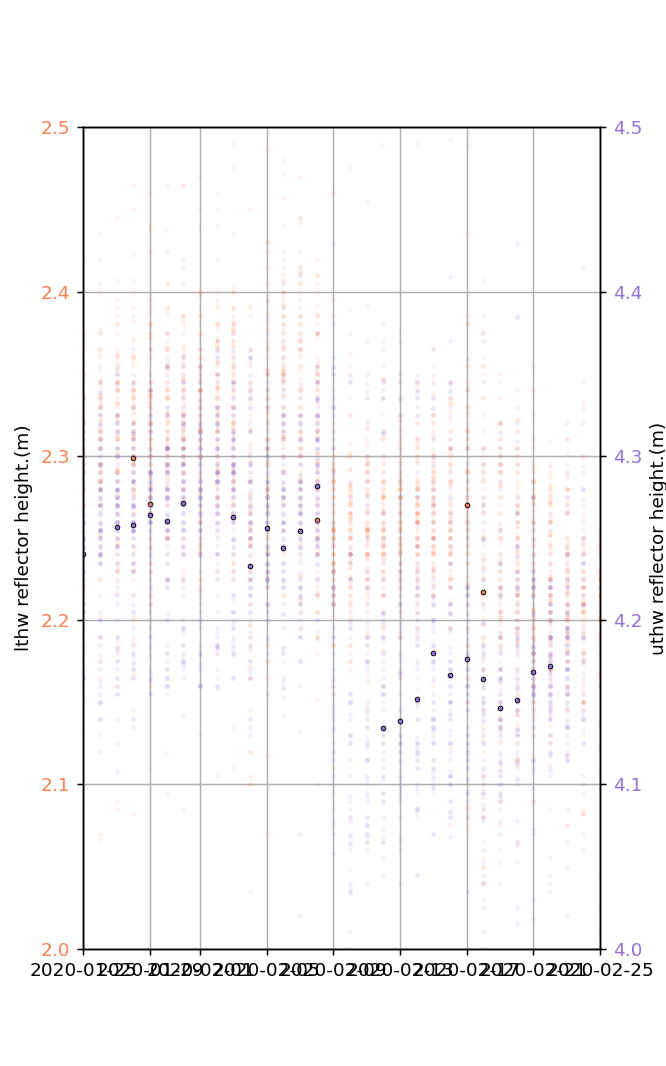

In [35]:
fig, ax1 = plt.subplots(figsize=(5,8))
ax1.plot(lthw[' RH(m)'],'.',markersize=5,markeredgewidth=0.0,alpha=.1,color='coral')
ax1.plot(lthw_median['mean'],'.',markersize=5,markeredgewidth=0.5,markeredgecolor='k',label='lthw',color='coral')
ax1.tick_params(axis='y', labelcolor='coral')
ax1.set_ylabel('lthw reflector height.(m)')
ax1.set_ylim(2,2.5)

ax2 = ax1.twinx()
ax2.plot(uthw[' RH(m)'],'.',markersize=5,markeredgewidth=0.0,alpha=.1,color='mediumpurple')
ax2.plot(uthw_median['mean'],'.',markersize=5,markeredgewidth=0.5,markeredgecolor='k',label='uthw',color='mediumpurple')
ax2.tick_params(axis='y', labelcolor='mediumpurple')
ax2.set_ylabel('uthw reflector height.(m)')
ax2.set_ylim(4,4.5)

#change the marker size manually for both lines
ax1.set_xlim(pd.Timestamp('2020-01-25'), pd.Timestamp('2020-02-25'))
ax1.grid()

# Preprocess the GNSS timeseries

The timeseries presented here relies on independently processed daily median GNSS-IR reflector heights. For information on the reflector height claculations, please refer to Larson et al (2014), and Roesler and Larson (2018). We first clean up this timeseries and fix locations where the reflector dips below 1m (and where the surface reflections become unreliable fewer ) 

# Define the forward model

In order to invert for the accumulation and physical properties of snow, we need a forward model. This model will allow us to use estimates (or random samples) for the accumulation history, snow density profiles with depth, snow viscosity, and new snow density to output consequent histories of reflector height change. In our snow model, we assume that snow layers settle by the combined effect of grain metamorphism and the overburden stress of the above layers. We can use a settling law established by Navarre (1975):

$$\frac{de}{e} = -\frac{\sigma}{\eta} dt$$

where $e$ is the layer thickness, $\sigma$ is the vertical overburden stress, and $dt$ is the time step for the layer thickness change. The overburden stress, $\sigma$, will change as new snow falls on the surface but at each timestep in our model we can write the stress, at layer depth, $D_i= \sum_1^i e_i$, for each layer $i$ in our snow pack as


$$\sigma_i = \sum_1^{i-1} g \rho_i e_i$$








In [36]:

def model(layerthickness, acc_t, rho_o, total_time, rho_snow, eta0, n_tsteps=365):
    """ Return the surface height of the reflector
    
    Parameters
    ---------
    layerthickness: np.ndarray(len(depth) x 1)
        The thickness of the intial layers (e, form Navarre)
    acc_t: np.ndarray(n_tsteps x 1)
        daily accumulation rate
    initial density: np.ndarray(len(depth) x 1)
        estimate for the initial density of the snow pack (assumed to be nearly linear)
    total_time: float
        total time of the model run
    rho_snow: float
        new snow density
    eta0: float
        snow viscosity
    n_tsteps: int
        number of time steps in model run

    Returns
    ---------    
    reflector height: nparray
    
    """


    timestep_size = total_time / n_tsteps
    rho_t=rho_o
    RH = np.zeros(len(acc_t))
    for step in range(n_tsteps):
        RH[step],rho_t,layerthickness = model_step(rho_t, acc_t[step],layerthickness,eta0,rho_snow=rho_snow, timestep_size=timestep_size,)

    return RH
        
def model_step(rho, acc_current, layerthickness,eta,timestep_size=86400,rho_snow=270.0, Hpole = 6.120):
    """simple model for snow densification (assuming snow is a viscous fluid).
    
    
    Parameters
    ---------
    rho: np.ndarray(variable)
        updated density profile
    layerthickness: np.ndarray(varibale)
        depth of snow parcels
    acc_current: float
        history of daily accumulation
    eta: float
        snow viscosity
    timestep_size: float
        size of timestep
    rho_snow: float
        new snow density
    Hpole: float
        total length of pole used to anchor antenna

        
        
    Returns
    ---------    
    reflector height: float
    
    """
    g = 9.8
    D_new=layerthickness.copy()
    rho_new=rho.copy()
    if acc_current != 0.0:
        D_new=np.insert(D_new,0,acc_current)
        rho_new=np.insert(rho_new,0,rho_snow)
        

    
    M = np.multiply(D_new,rho_new) 

    sig_z = np.cumsum(-g * M)
    dDD = sig_z/eta * timestep_size
    Dnew=np.multiply(1.0+dDD,D_new)
    rhonew=np.multiply(M,1.0/Dnew)

    RH = Hpole - np.sum(Dnew)

    return RH,rhonew,Dnew


## Model testing
We can test this model using random accumulation rates assuming a density profile that varies almost linearly between 300 kg/m$^3$ and  400 kg/m$^3$


## Cost function
We have a forward model for snow densification. We can now define a cost function that evalutes how well our model matches our reflectometry data. To do this, we must regularize error by weighting the misfit at the beginning of the record more than the misfit at the endd of the record because any misfit at the beginning of our record will propogate through the entire solution. We also regularize with respect to the final reflector height difference.

In [48]:
def cost(modeled_surface, measured_surface, measured_error, acc,rho0,eta,rhonew, regularization=100.0,nsteps=365):
    """Return the cost function given the measured layer and our model output
    
    Parameters
    ----------
    modeled_surface: np.ndarray(n x 1)
        The model output
    measured_surface: np.ndarray(n x 1)
        The data
    regularization: float
        A scaling of the total variation to add to the misfit when determining the cost function (really just for the initial density estimate.
        This will need to be tuned if used. Turn off by setting to zero.
        
    Returns
    cost_reg: float
        The misfit/objective function/cost function
    cost_unreg: float
        The misfit/objective function/cost function without regularization. Useful for comparing regularizations
    """
    #create regularization vector for accumulation, initial density variations.
    
    
    measured_difference=np.diff(measured_surface[~np.isnan(measured_surface)])
    modeled_difference=np.zeros(len(measured_difference))
    ind_data=np.argwhere(~np.isnan(measured_surface)).transpose()[0]
    for i in range(len(ind_data)-1):
        j=ind_data[i]
        k=ind_data[i+1]
        modeled_difference[i]=np.sum(np.diff(modeled_surface[j:k+1]))


    if regularization > 0:
        #slope, intercept, r_value, p_value, std_err = stats.linregress(x_cost,modeled_surface)
        #slope_measured, intercept, r_value, p_value, std_err=  stats.linregress(x_cost,measured_surface)
        
        reg = regularization
    
    else:
        reg = 0.0
        
    unreg_cost = 1/2*np.nansum((measured_surface-modeled_surface)**2/(measured_error**2))
    
    return np.nansum(unreg_cost* reg), unreg_cost

## Test the Cost function
We can test the cost function by evaluting the cost of a solution that we know is going to be pretty close- the difference of the measured surface height change and compare this result with a random accumulation history with maximum amplitude of 10cm per day.

# Monte Carlo
We can now use our model for snow densification and our cost function to work towards a good solution for snow surface height. We are going to need to determine transition probabilities to sample the possible space. Let's combine some equations from Sambridge.

$$p(m_k) = A \exp{(-B\phi(m_k))}$$

and

$$P_{\textrm{accept}} = \min\left(1, \frac{p(m_{i + 1})}{p(m_{i})}\right)$$

If we sub in the first to the second
$$P_{\textrm{accept}} = \min\left(1, \frac{A \exp{(-B\phi(m_{i + 1}))}}{A \exp{(-B\phi(m_{i}))}}\right)=\min\left(1, \exp\left(-B(\phi(m_{i+1})-\phi(m_i))\right)\right)$$

Here $B$ is now a tunable parameter to get our algorithm to work. Luckily, it works with no tuning, so take it to be one. If we wanted to do simulated annealing, would could retain it and make it time-decaying.


<IPython.core.display.Javascript object>


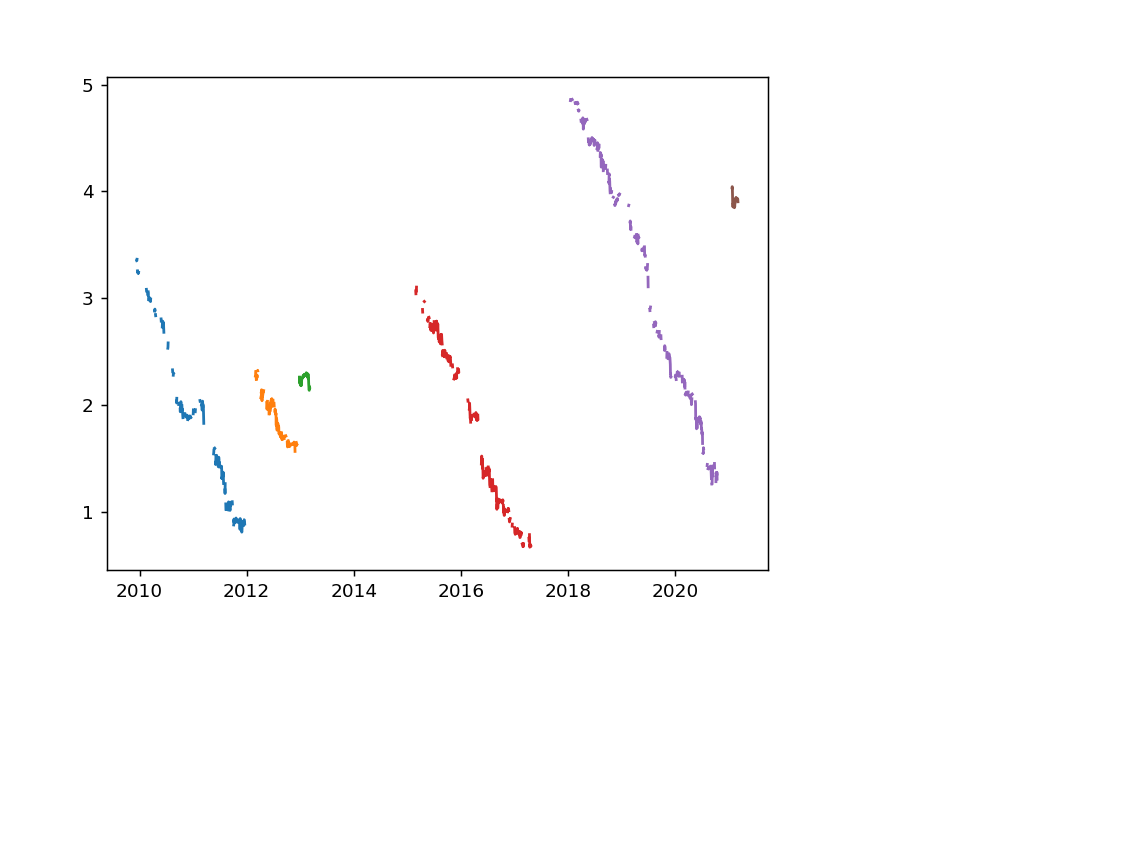

In [202]:
plt.subplots()
plt.plot(lthw_median[:762]['mean'])
plt.plot(lthw_median[773:1095]['mean'])
plt.plot(lthw_median[1096:1181]['mean'])
plt.plot(lthw_median[1855:2700]['mean'])
plt.plot(lthw_median[2949:3958]['mean'])
plt.plot(lthw_median[4059:4100]['mean'])

<IPython.core.display.Javascript object>


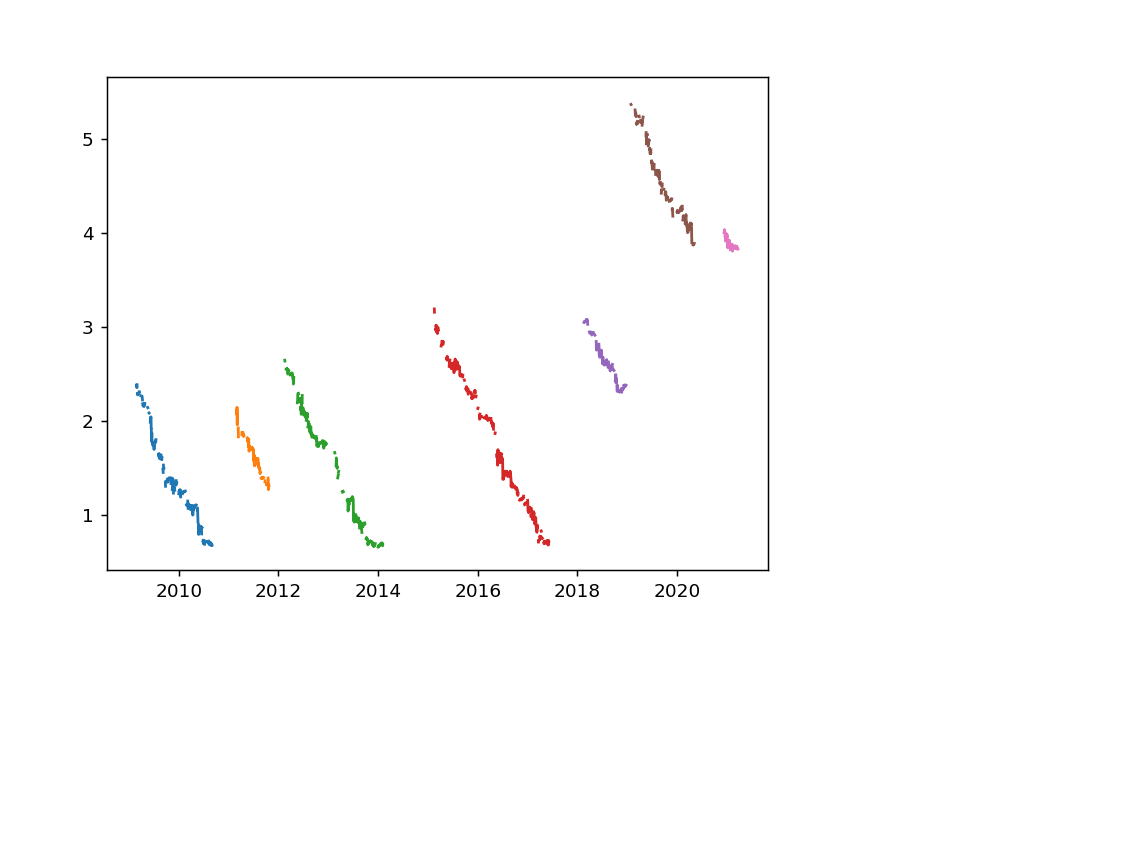

In [50]:
plt.subplots()
plt.plot(uthw_median[:615]['mean'])
plt.plot(uthw_median[742:1085]['mean'])
plt.plot(uthw_median[1085:1861]['mean'])
plt.plot(uthw_median[2200:3080]['mean'])
plt.plot(uthw_median[3305:3667]['mean'])
plt.plot(uthw_median[3668:3958]['mean'])
plt.plot(uthw_median[4362:4464]['mean'])

<IPython.core.display.Javascript object>


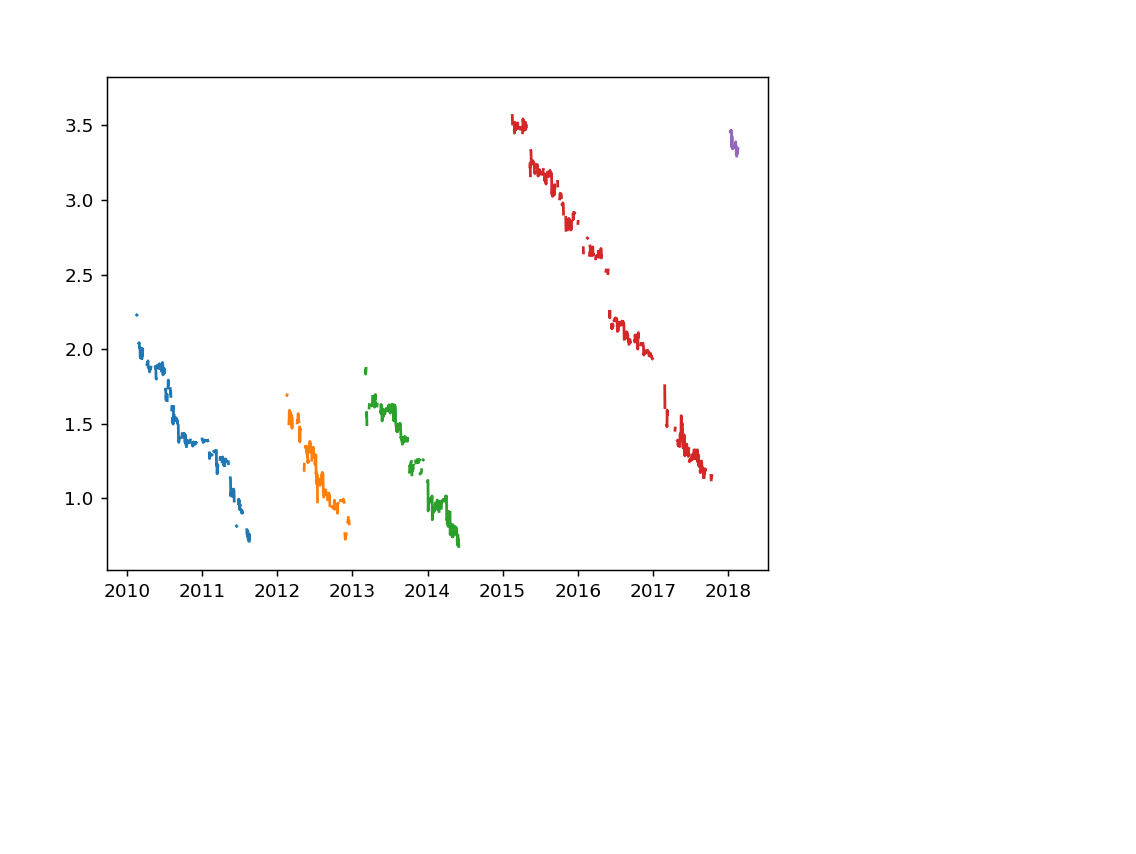

In [179]:
plt.subplots()
plt.plot(khlr_median[:634]['mean'])
plt.plot(khlr_median[694:1086]['mean'])
plt.plot(khlr_median[1087:1621]['mean'])
plt.plot(khlr_median[1760:2870]['mean'])
plt.plot(khlr_median[2910:2950]['mean'])

In [203]:
khlr_ind=[[24,573+1],[694+14,494+363+1],[1087+34,1087+532+1],[1760+70,1760+1063+1],[2910,2910+37+1]]
lthw_ind=[[1,737+1],[773+25,773+320+1],[1096+14,1096+84+1],[1855+48,1855+840+1],[2949+6,3958],[4059,4059+40+1]]
uthw_ind=[[57,609+1],[742+48,742+284+1],[1086+11,1086+774+1],[2200+38,2200+877+1],[3305+29,3305+338+1],[3668,3668+475+1],[4362,4362+101+1]]

In [204]:
def monte_carlo_run(rho0,acc0,rho_new,eta,D,RH_data,RH_error,
                    n_tsteps,
                    n_iterates=2 * 10 ** 4,
                    stepsize=0.001,
                    regularization=0.0):
    """Perform a suite of runs to get our distribution. We start with an initial guess, and move around.
    
    Parameters
    ----------
    rho0: np.ndarray(lengh(depth)x1)
        Initial density
    acc0: np.ndarray(n_tstepsx1)
        initial accumulation history
    rhow_new: float
        new snow density
    total_time: float, optional
        Time over which to run the model
    n_tsteps: int, optional
        Number of degrees of freedom each for accumulation variable
    n_iterates: int, optional
        Number of accepted models to run to.
    stepsize: float, optional
        Perturbation size for each new model.
    regularization: float, optional
        Regularize the output by scaling the square total variation by this amount. Should be >=0.0, and =0 if unregularized.
    
    Returns
    -------
    outputs: np.ndarray (n_tsteps * (len(acc0)+ len(rho0)+2) x n_iterates)
        The model inputs that have been accepted. The first will be the initial guess.
    misfits: np.ndarray (n_iterates x 2)
        Cost function with and without regularization. First column is regularized, second isn't.
    """
    total_time=n_tsteps*86400
    # this is just to check how long it took
    now = time.time()
    
    l=int(len(rho0)+len(acc0)+2)
    # Preallocate locations for output--we want all our accepted models saved
    outputs = np.zeros((l,n_iterates))
    # misfits will have both a regularized and an unregularized row
    misfits = np.zeros((n_iterates, 2))
    
    # variable to increment--we use a while loop rather than a for loop since sometimes we dont step, and thus
    # we do no know how many times we will actually execute the loop
    i = 0
    vector_inputs=np.append(rho0,acc0)
    vector_inputs=np.append(vector_inputs,rho_new)
    vector_inputs=np.append(vector_inputs,eta)
    # fencepost; this is so we don't have errors comparing to previous state
    RH = model(D,acc0,rho0,total_time,rho_new,eta, n_tsteps=n_tsteps)
    outputs[:, i] = vector_inputs
    misfits[i] = cost(RH,RH_data,RH_error,acc0,rho0,eta,rho_new,regularization=regularization,nsteps=n_tsteps)
    # This is the real bulk of the work--keep trying to make steps downward
    while i < n_iterates - 1:
        # start by perturbing--first copy our vector to avoid modifying original in case we dont step
 
        vector_inputs_pert = vector_inputs.copy()

        # randint gives us a random component of the vector to perturb
        rand_ind = randint(0, len(vector_inputs)-1)
        # We use a normal distribution with variance "stepsize" for the perturbation
        if rand_ind>len(rho0)-1 and rand_ind<len(vector_inputs_pert)-2:
            vector_inputs_pert[rand_ind] = vector_inputs_pert[rand_ind] + gauss(0, stepsize*10.)
        elif rand_ind<len(rho0) or rand_ind ==len(vector_inputs_pert)-2:
            vector_inputs_pert[rand_ind] = vector_inputs_pert[rand_ind] + gauss(0, stepsize*3000.)
        else:
            vector_inputs_pert[rand_ind] = vector_inputs_pert[rand_ind] + gauss(0, stepsize*10e13)
            
        # enforce that accumulation density and viscosity are strictly positive
        if vector_inputs_pert[rand_ind] < 0:
            vector_inputs_pert[rand_ind] = 0.0
            # if not positive, we don't save the perturbed state and we just restart this iteration of the while loop
        
        #evaluate model
        
        rho=vector_inputs_pert[:len(rho0)]
        acc=vector_inputs_pert[len(rho0):][:len(acc0)]
        rho_new=vector_inputs_pert[len(rho0):][len(acc0):][0]
        eta=vector_inputs_pert[len(rho0):][len(acc0):][1]
        
        #RH = model(x, vx_and_acc_of_t_pert, acc_rate, vels, total_time, n_tsteps=n_tsteps)
        RH = model(D,acc,rho,total_time,rho_new,eta, n_tsteps=n_tsteps)
        # see if model is any good---store cost function in vector, will be overwritten if not chosen
        misfits[i + 1, :] = cost(RH,RH_data,RH_error,acc,rho,eta,rho_new, regularization=regularization,nsteps=n_tsteps)
        
        try:
            test = exp(-(misfits[i + 1, 0] - misfits[i, 0]))
        except OverflowError:
            test = float(1.0)
        
        # Decide whether to accept our new guess
        if i < 1 or rand() < min(1,test):
            # We have accepted the model! We need to store it, and save this state as the new model to step from
            outputs[:, i + 1] = vector_inputs_pert
            vector_inputs = vector_inputs_pert.copy()
            
            # increment only upon acceptance of the guess
            i += 1

    print('Run took {:5.1f}s'.format(time.time() - now))
    return outputs, misfits

## Model Evaluation
We can now use the model and the monte carlo algorithm we've defined above to try and infer an accumulation record at the site of our GPS. We load everying in and again assume an accumulation record equal to all of the negative surface height changes. We could also guess solutions far from the correct one by assuming a constant accumulation every day of 30 cm/day, or a random accumulation history centered around 5 cm/day.

In [205]:
rho_new = 300.
eta = .7*10**7*86400. #This estimate is based on the value recorded from 

lthw_record=np.zeros(len(lthw_median))
lthw_record[:]=np.nan
outputs=[]
misfits=[]

for i in range(len(lthw_ind)):
    RHdata=(lthw_median['mean'].to_numpy()[lthw_ind[i][0]:lthw_ind[i][1]])
    RHerror=(lthw_median['std'].to_numpy()[lthw_ind[i][0]:lthw_ind[i][1]])
    n_steps=lthw_ind[i][1]-lthw_ind[i][0]
    depth0 = 6.120-np.nanmean(RHdata[:4])
    acc0=np.diff(RHdata,axis=0)
    acc0=np.append([0.],-1.0*acc0)
    acc0[np.isnan(acc0)]=0.0
    acc0[acc0<0]=0.0
    D0=depth0/1.*np.ones(1, dtype=float)
    rho0=np.arange(300,400,100./len(D0))
    l=len(acc0)+len(rho0)+2
    iterations=100*(len(acc0)+len(rho0)+2)
    outputs_tmp, misfits_tmp = monte_carlo_run(rho0,acc0,rho_new,eta,D0,RHdata,RHerror,n_steps,n_iterates=iterations,regularization=100.0)#1000.0)
    
    outputs.append(outputs_tmp)
    misfits.append(misfits_tmp)


Run took 12560.7s
Run took 2128.0s
Run took 106.0s
Run took 16826.5s
Run took 20577.3s


<ipython-input-36-9cbd8574ec39>:76: RuntimeWarning: divide by zero encountered in true_divide
  dDD = sig_z/eta * timestep_size
<ipython-input-36-9cbd8574ec39>:73: RuntimeWarning: invalid value encountered in multiply
  M = np.multiply(D_new,rho_new)


Run took  26.6s


In [67]:
best = np.argmin(misfits[0][:, 0])
rho0best=outputs[0][:,best][:len(rho0)]
accbest=outputs[0][:,best][len(rho0):][:len(acc0)]
rho_newbest=outputs[0][:,best][len(rho0):][len(acc0):][0]
etabest=outputs[0][:,best][len(rho0):][len(acc0):][1]

<IPython.core.display.Javascript object>


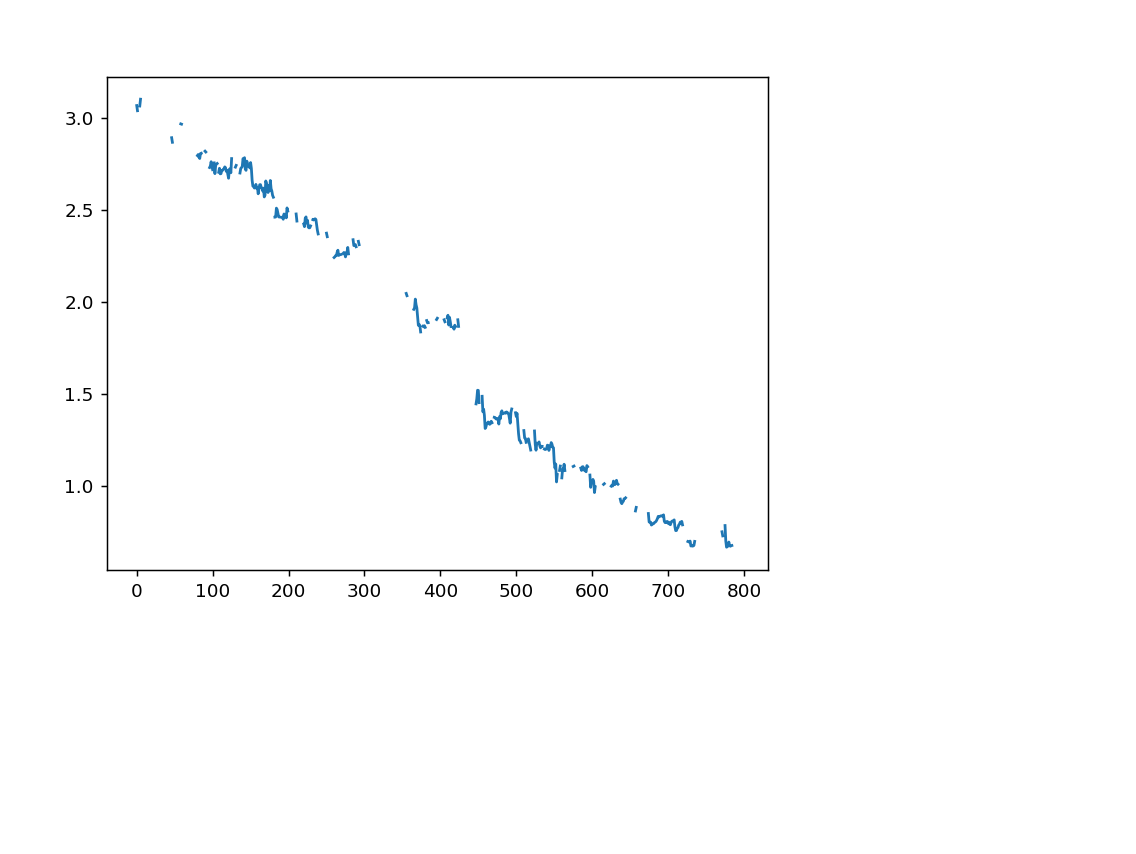

In [62]:
plt.subplots()
plt.plot(RHdata)

<IPython.core.display.Javascript object>


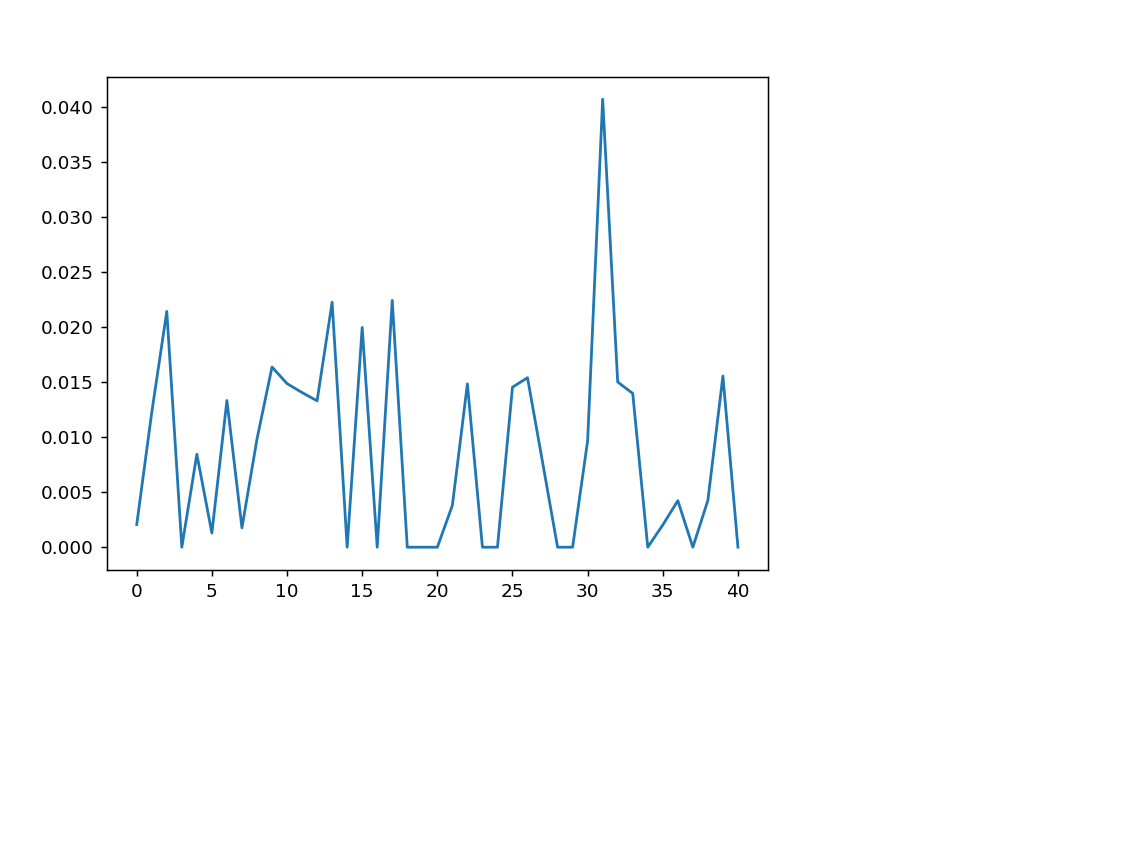

In [68]:
plt.subplots()
plt.plot(accbest)

In [82]:
best = np.argmin(misfits[0][:, 0])
accbest=outputs[0][:,best][len(rho0):][:len(acc0)]

<IPython.core.display.Javascript object>


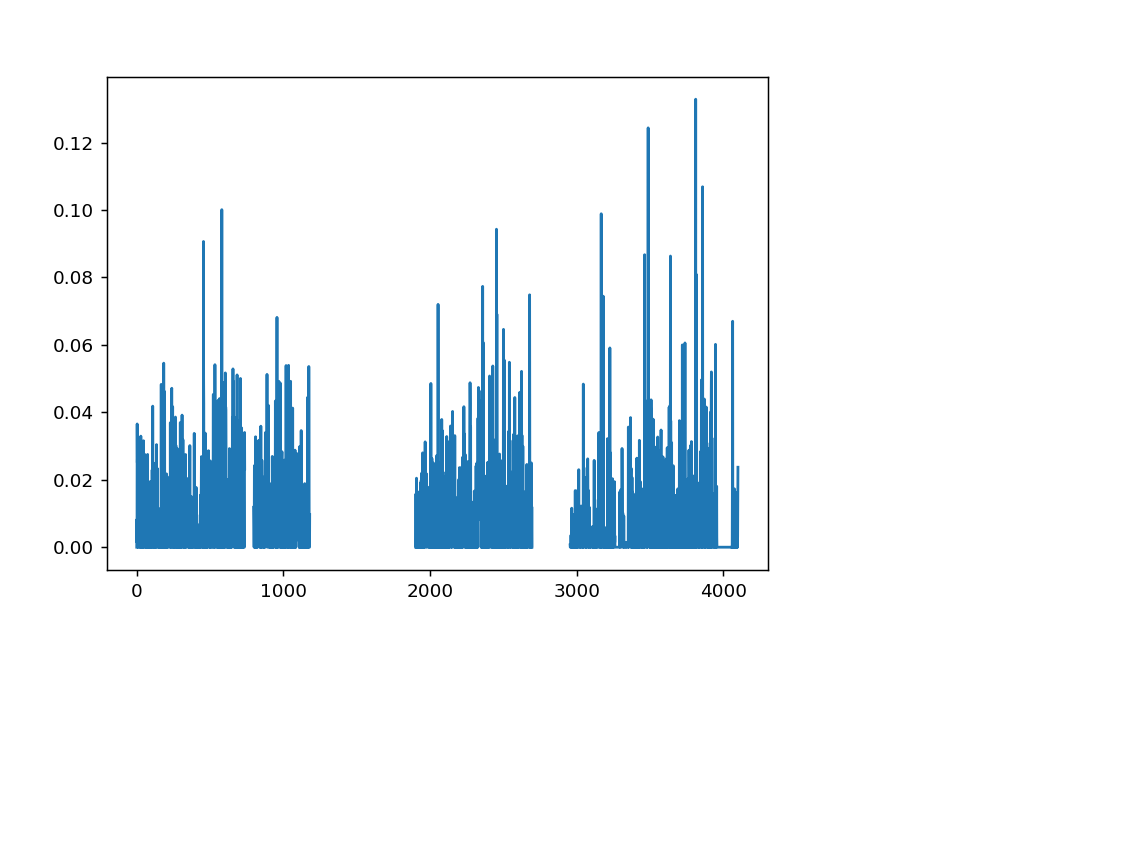

In [158]:
plt.subplots()
plt.plot(lthw_record)

In [135]:
outputs[4].shape

(1106, 100000)

328331088156.5121
358.1696797776856


<IPython.core.display.Javascript object>


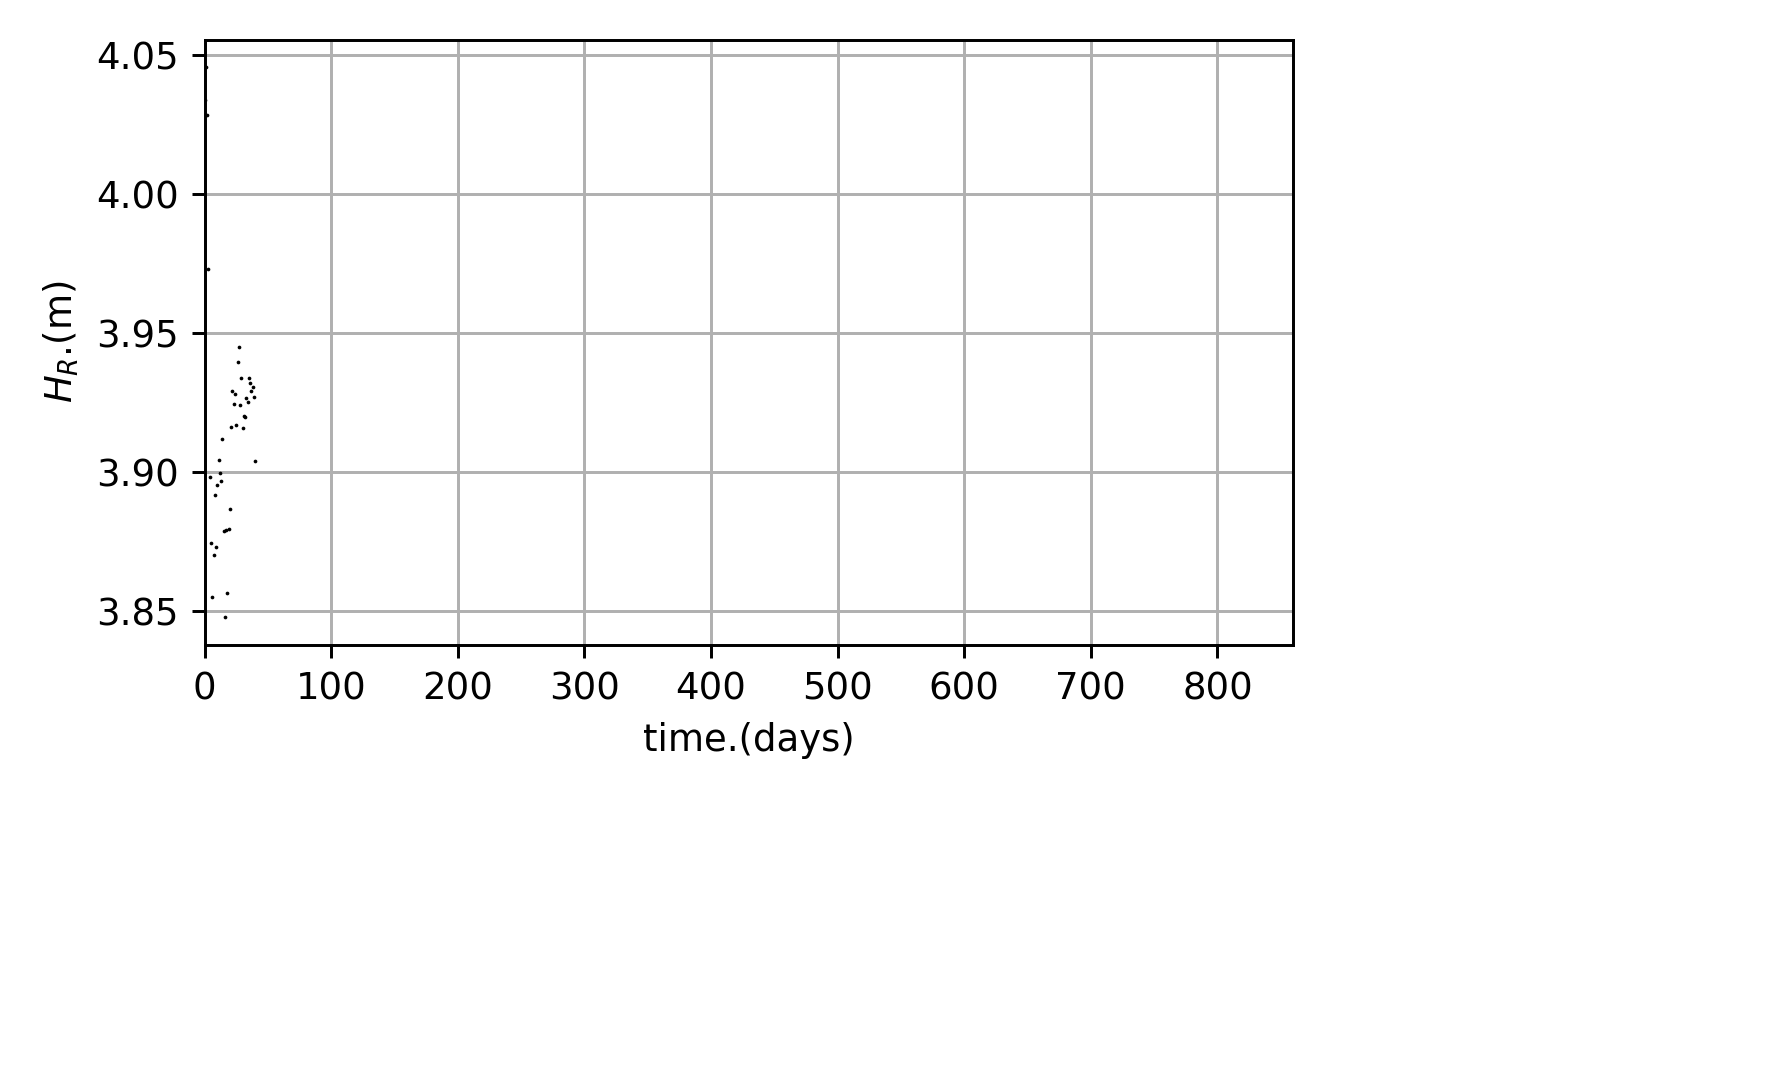

<ipython-input-36-9cbd8574ec39>:76: RuntimeWarning: divide by zero encountered in true_divide
  dDD = sig_z/eta * timestep_size
<ipython-input-36-9cbd8574ec39>:73: RuntimeWarning: invalid value encountered in multiply
  M = np.multiply(D_new,rho_new)
<ipython-input-36-9cbd8574ec39>:76: RuntimeWarning: invalid value encountered in true_divide
  dDD = sig_z/eta * timestep_size
<ipython-input-36-9cbd8574ec39>:76: RuntimeWarning: divide by zero encountered in true_divide
  dDD = sig_z/eta * timestep_size
<ipython-input-36-9cbd8574ec39>:73: RuntimeWarning: invalid value encountered in multiply
  M = np.multiply(D_new,rho_new)
<ipython-input-36-9cbd8574ec39>:76: RuntimeWarning: invalid value encountered in true_divide
  dDD = sig_z/eta * timestep_size
<ipython-input-36-9cbd8574ec39>:76: RuntimeWarning: divide by zero encountered in true_divide
  dDD = sig_z/eta * timestep_size
<ipython-input-36-9cbd8574ec39>:73: RuntimeWarning: invalid value encountered in multiply
  M = np.multiply(D_new,rh

<ipython-input-36-9cbd8574ec39>:73: RuntimeWarning: invalid value encountered in multiply
  M = np.multiply(D_new,rho_new)
<ipython-input-36-9cbd8574ec39>:76: RuntimeWarning: invalid value encountered in true_divide
  dDD = sig_z/eta * timestep_size
<ipython-input-36-9cbd8574ec39>:76: RuntimeWarning: divide by zero encountered in true_divide
  dDD = sig_z/eta * timestep_size
<ipython-input-36-9cbd8574ec39>:73: RuntimeWarning: invalid value encountered in multiply
  M = np.multiply(D_new,rho_new)
<ipython-input-36-9cbd8574ec39>:76: RuntimeWarning: invalid value encountered in true_divide
  dDD = sig_z/eta * timestep_size
<ipython-input-36-9cbd8574ec39>:76: RuntimeWarning: divide by zero encountered in true_divide
  dDD = sig_z/eta * timestep_size
<ipython-input-36-9cbd8574ec39>:73: RuntimeWarning: invalid value encountered in multiply
  M = np.multiply(D_new,rho_new)
<ipython-input-36-9cbd8574ec39>:76: RuntimeWarning: invalid value encountered in true_divide
  dDD = sig_z/eta * timestep

In [159]:

print(etabest)
print(rho_newbest)

doy = np.arange(0,n_steps,1)
depth = np.cumsum(D0)

num_samples =20

colormap = plt.get_cmap('coolwarm')


#def model(layerthickness, acc_t, rho_o, total_time, rho_snow, eta0, n_tsteps=200):
nsamples =10

fig2, ax2 = plt.subplots(figsize=(5,3),dpi=200)
for n in range(0,iterations,math.floor(iterations/100)):
    D=D0
    RH = model(D,outputs[4][:,n][len(rho0):][:len(acc0)], outputs[4][:,n][:len(rho0)],n_steps*86400,outputs[4][:,n][len(rho0):][len(acc0):][0],outputs[4][:,n][len(rho0):][len(acc0):][1],n_tsteps=n_steps)
    ax2.plot(RH,
            color=colormap((n + 1) / iterations))

RHbest=model(D,accbest, rho0best,n_steps*86400,rho_newbest,etabest,n_tsteps=n_steps)
ax2.plot(RHdata,'.',markersize=2,markeredgewidth=0.0, color='k')
#ax2.plot(RHbest , color='r')
ax2.set_xlabel('tim\
e.(days)')
ax2.set_ylabel(r'$H_R$.(m)')
ax2.set_xlim(0,860)
ax2.grid()
plt.tight_layout()
plt.close(fig)


In [206]:
lthw_record=np.zeros(len(lthw_median))
lthw_record[:]=np.nan
for i in range(len(lthw_ind)):
    RHdata=(lthw_median['mean'].to_numpy()[lthw_ind[i][0]:lthw_ind[i][1]])
    RHerror=(lthw_median['std'].to_numpy()[lthw_ind[i][0]:lthw_ind[i][1]])
    n_steps=lthw_ind[i][1]-lthw_ind[i][0]
    depth0 = 6.120-np.nanmean(RHdata[:4])
    acc0=np.diff(RHdata,axis=0)
    acc0=np.append([0.],-1.0*acc0)
    acc0[np.isnan(acc0)]=0.0
    acc0[acc0<0]=0.0
    D0=depth0/1.*np.ones(1, dtype=float)
    rho0=np.arange(300,400,100./len(D0))
    best = np.argmin(misfits[i][:, 0])
    rho0best=outputs[i][:,best][:len(rho0)]
    accbest=outputs[i][:,best][len(rho0):][:len(acc0)]
    rho_newbest=outputs[i][:,best][len(rho0):][len(acc0):][0]
    etabest=outputs[i][:,best][len(rho0):][len(acc0):][1]
    lthw_record[lthw_ind[i][0]:lthw_ind[i][1]]=accbest
    
    

In [176]:
lthw_ind

[[1, 738], [798, 1094], [1110, 1181], [1903, 2696], [2955, 4058], [4059, 4100]]

In [165]:
uthw_record=np.zeros(len(uthw_median))
uthw_record[:]=np.nan
best =[]
rho0best=[]
accbest=[]
rho_newbest=[]
etabest=[]
for i in range(len(uthw_ind)):
    RHdata=(uthw_median['mean'].to_numpy()[uthw_ind[i][0]:uthw_ind[i][1]])
    RHerror=(uthw_median['std'].to_numpy()[uthw_ind[i][0]:uthw_ind[i][1]])
    n_steps=uthw_ind[i][1]-uthw_ind[i][0]
    depth0 = 6.120-np.nanmean(RHdata[:4])
    acc0=np.diff(RHdata,axis=0)
    acc0=np.append([0.],-1.0*acc0)
    acc0[np.isnan(acc0)]=0.0
    acc0[acc0<0]=0.0
    D0=depth0/1.*np.ones(1, dtype=float)
    rho0=np.arange(300,400,100./len(D0))
    best = np.argmin(uthw_misfits[i][:, 0])
    rho0best=uthw_outputs[i][:,best][:len(rho0)]
    accbest=uthw_outputs[i][:,best][len(rho0):][:len(acc0)]
    rho_newbest=uthw_outputs[i][:,best][len(rho0):][len(acc0):][0]
    etabest=uthw_outputs[i][:,best][len(rho0):][len(acc0):][1]
    uthw_record[uthw_ind[i][0]:uthw_ind[i][1]]=accbest
    best =[]
    rho0best=[]
    accbest=[]
    rho_newbest=[]
    etabest=[]
    

In [169]:
khlr_record=np.zeros(len(khlr_median))
khlr_record[:]=np.nan
best =[]
rho0best=[]
accbest=[]
rho_newbest=[]
etabest=[]
for i in range(len(khlr_ind)):
    RHdata=(khlr_median['mean'].to_numpy()[khlr_ind[i][0]:khlr_ind[i][1]])
    RHerror=(khlr_median['std'].to_numpy()[khlr_ind[i][0]:khlr_ind[i][1]])
    n_steps=lthw_ind[i][1]-lthw_ind[i][0]
    depth0 = 6.120-np.nanmean(RHdata[:4])
    acc0=np.diff(RHdata,axis=0)
    acc0=np.append([0.],-1.0*acc0)
    acc0[np.isnan(acc0)]=0.0
    acc0[acc0<0]=0.0
    D0=depth0/1.*np.ones(1, dtype=float)
    rho0=np.arange(300,400,100./len(D0))
    best = np.argmin(khlr_misfits[i][:, 0])
    rho0best=khlr_outputs[i][:,best][:len(rho0)]
    accbest=khlr_outputs[i][:,best][len(rho0):][:len(acc0)]
    rho_newbest=khlr_outputs[i][:,best][len(rho0):][len(acc0):][0]
    etabest=khlr_outputs[i][:,best][len(rho0):][len(acc0):][1]
    khlr_record[khlr_ind[i][0]:khlr_ind[i][1]]=accbest
    best =[]
    rho0best=[]
    accbest=[]
    rho_newbest=[]
    etabest=[]
    

<IPython.core.display.Javascript object>


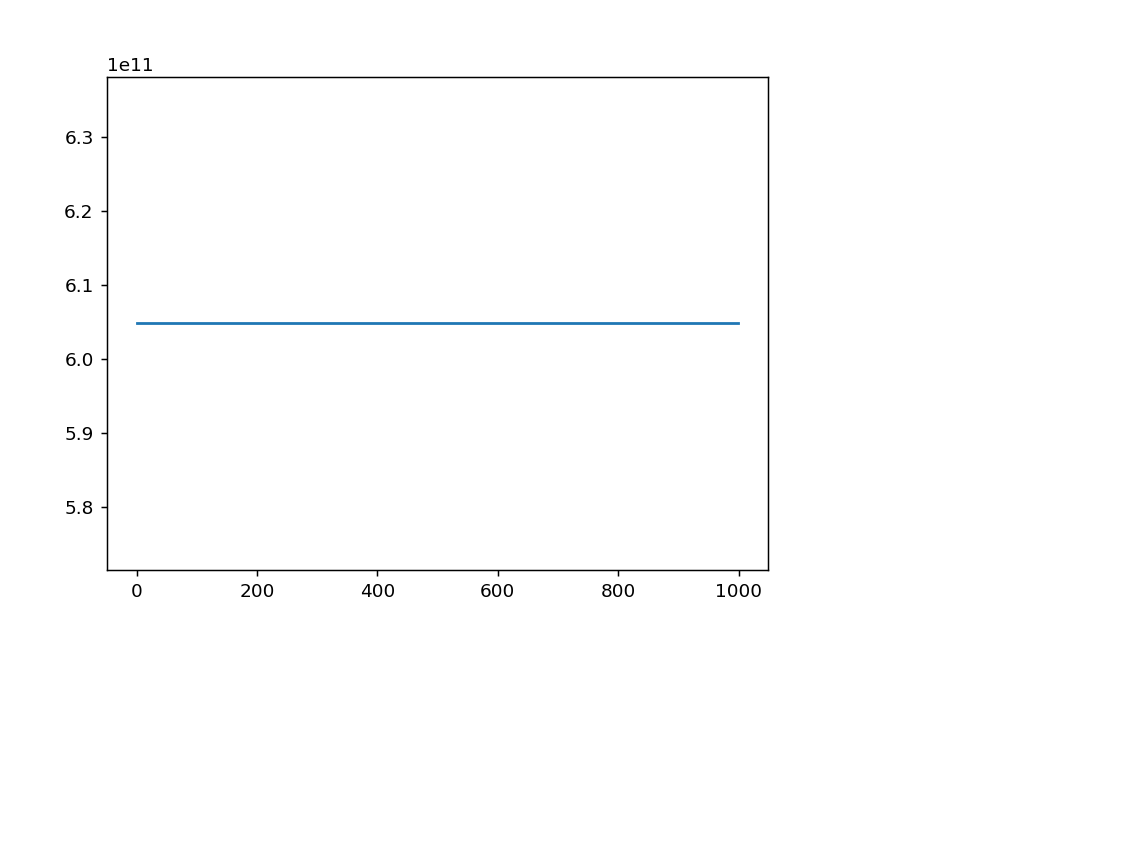

In [149]:
plt.subplots()
plt.plot(outputs[4][1105,:])

<IPython.core.display.Javascript object>


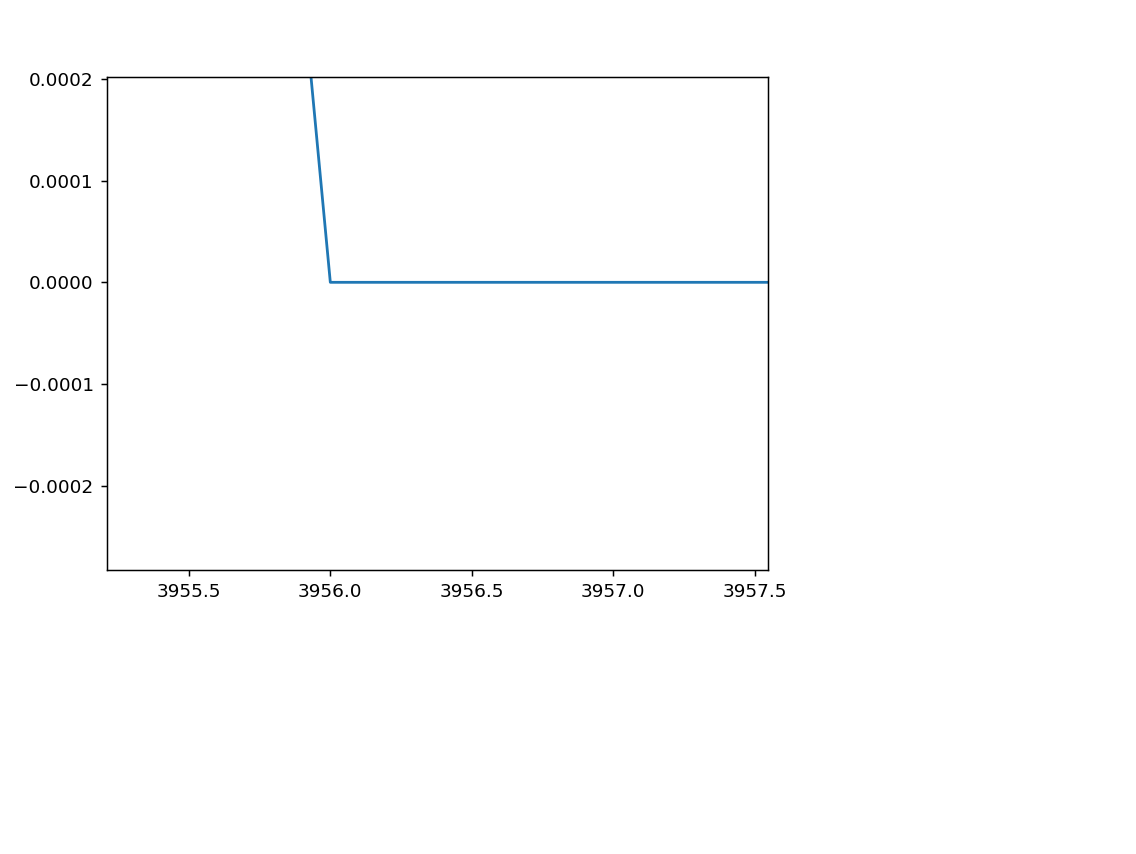

In [175]:
plt.subplots()
plt.plot(lthw_record)

In [160]:
rho_new = 300.
eta = .9*10**7*86400. #This estimate is based on the value recorded from 

khlr_record=np.zeros(len(khlr_median))
khlr_record[:]=np.nan
khlr_outputs=[]
khlr_misfits=[]
for i in range(len(khlr_ind)):
    RHdata=(khlr_median['mean'].to_numpy()[khlr_ind[i][0]:khlr_ind[i][1]])
    RHerror=(khlr_median['std'].to_numpy()[khlr_ind[i][0]:khlr_ind[i][1]])
    n_steps=khlr_ind[i][1]-khlr_ind[i][0]
    depth0 = 6.120-np.nanmean(RHdata[:4])
    acc0=np.diff(RHdata,axis=0)
    acc0=np.append([0.],-1.0*acc0)
    acc0[np.isnan(acc0)]=0.0
    acc0[acc0<0]=0.0
    D0=depth0/1.*np.ones(1, dtype=float)
    rho0=np.arange(300,400,100./len(D0))
    l=len(acc0)+len(rho0)+2
    iterations=100*(len(acc0)+len(rho0)+2)
    outputs_tmp, misfits_tmp = monte_carlo_run(rho0,acc0,rho_new,eta,D0,RHdata,RHerror,n_steps,n_iterates=iterations,regularization=100.0)#1000.0)
    
    khlr_outputs.append(outputs_tmp)
    khlr_misfits.append(misfits_tmp)
    
    
    



Run took 7224.7s
Run took 473.2s
Run took 6129.6s
Run took 20699.8s
Run took  23.0s


In [161]:
rho_new = 300.
eta = .9*10**7*86400. #This estimate is based on the value recorded from 

uthw_record=np.zeros(len(uthw_median))
uthw_record[:]=np.nan

uthw_outputs=[]
uthw_misfits=[]
for i in range(len(uthw_ind)):
    RHdata=(uthw_median['mean'].to_numpy()[uthw_ind[i][0]:uthw_ind[i][1]])
    RHerror=(uthw_median['std'].to_numpy()[uthw_ind[i][0]:uthw_ind[i][1]])
    n_steps=uthw_ind[i][1]-uthw_ind[i][0]
    depth0 = 6.120-np.nanmean(RHdata[:4])
    acc0=np.diff(RHdata,axis=0)
    acc0=np.append([0.],-1.0*acc0)
    acc0[np.isnan(acc0)]=0.0
    acc0[acc0<0]=0.0
    D0=depth0/1.*np.ones(1, dtype=float)
    rho0=np.arange(300,400,100./len(D0))
    l=len(acc0)+len(rho0)+2
    iterations=100*(len(acc0)+len(rho0)+2)
    outputs_tmp, misfits_tmp = monte_carlo_run(rho0,acc0,rho_new,eta,D0,RHdata,RHerror,n_steps,n_iterates=iterations,regularization=100.0)#1000.0)
    
    uthw_outputs.append(outputs_tmp)
    uthw_misfits.append(misfits_tmp)
    



Run took 7885.7s
Run took 1269.1s
Run took 15666.2s
Run took 17191.0s
Run took 2002.6s
Run took 3721.6s
Run took 166.6s


In [207]:
khlr_median['accumulation']=khlr_record
lthw_median['accumulation']=lthw_record
uthw_median['accumulation']=uthw_record

In [208]:
khlr_median.to_csv('../../data/Files/khlr10162010-02142018.csv')
lthw_median.to_csv('../../data/Files/lthw12162009-10282020.csv')
uthw_median.to_csv('../../data/Files/uthw01012009-03232021.csv')

<IPython.core.display.Javascript object>


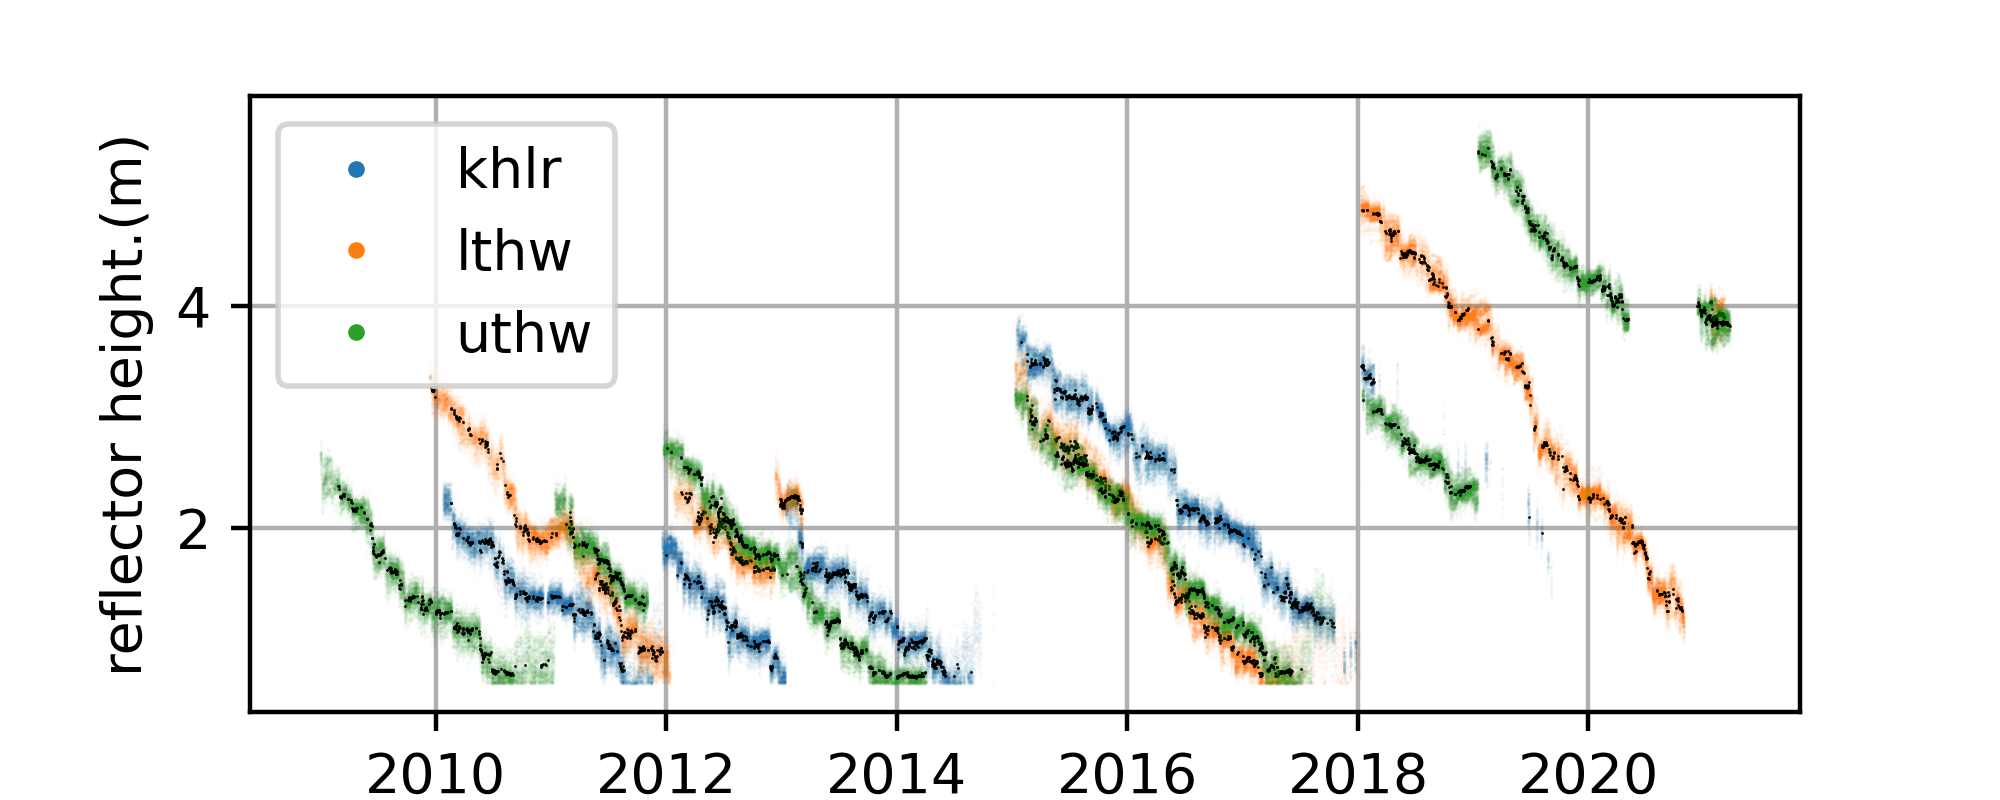

In [446]:
fig,ax=plt.subplots(figsize=(5,2),dpi=200)
ax.plot(khlr[' RH(m)'],'.',markersize=1,markeredgewidth=0.0,alpha=.02,label='khlr')
ax.plot(khlr_median['mean'],'.',markersize=1,markeredgewidth=0.0,color='k')
ax.plot(lthw[' RH(m)'],'.',markersize=1,markeredgewidth=0.0,alpha=.02,label='lthw')
ax.plot(lthw_median['mean'],'.',markersize=1,markeredgewidth=0.0,color='k')
ax.plot(uthw[' RH(m)'],'.',markersize=1,markeredgewidth=0.0,alpha=.02,label='uthw')
ax.plot(uthw_median['mean'],'.',markersize=1,markeredgewidth=0.0,color='k')

lgnd = ax.legend()

#change the marker size manually for both lines
lgnd.legendHandles[0]._legmarker.set_markersize(6)
lgnd.legendHandles[1]._legmarker.set_markersize(6)
lgnd.legendHandles[2]._legmarker.set_markersize(6)
lgnd.legendHandles[0]._legmarker.set_alpha(1)
lgnd.legendHandles[1]._legmarker.set_alpha(1)
lgnd.legendHandles[2]._legmarker.set_alpha(1)
ax.set_ylabel('reflector height.(m)')
ax.grid()

<IPython.core.display.Javascript object>


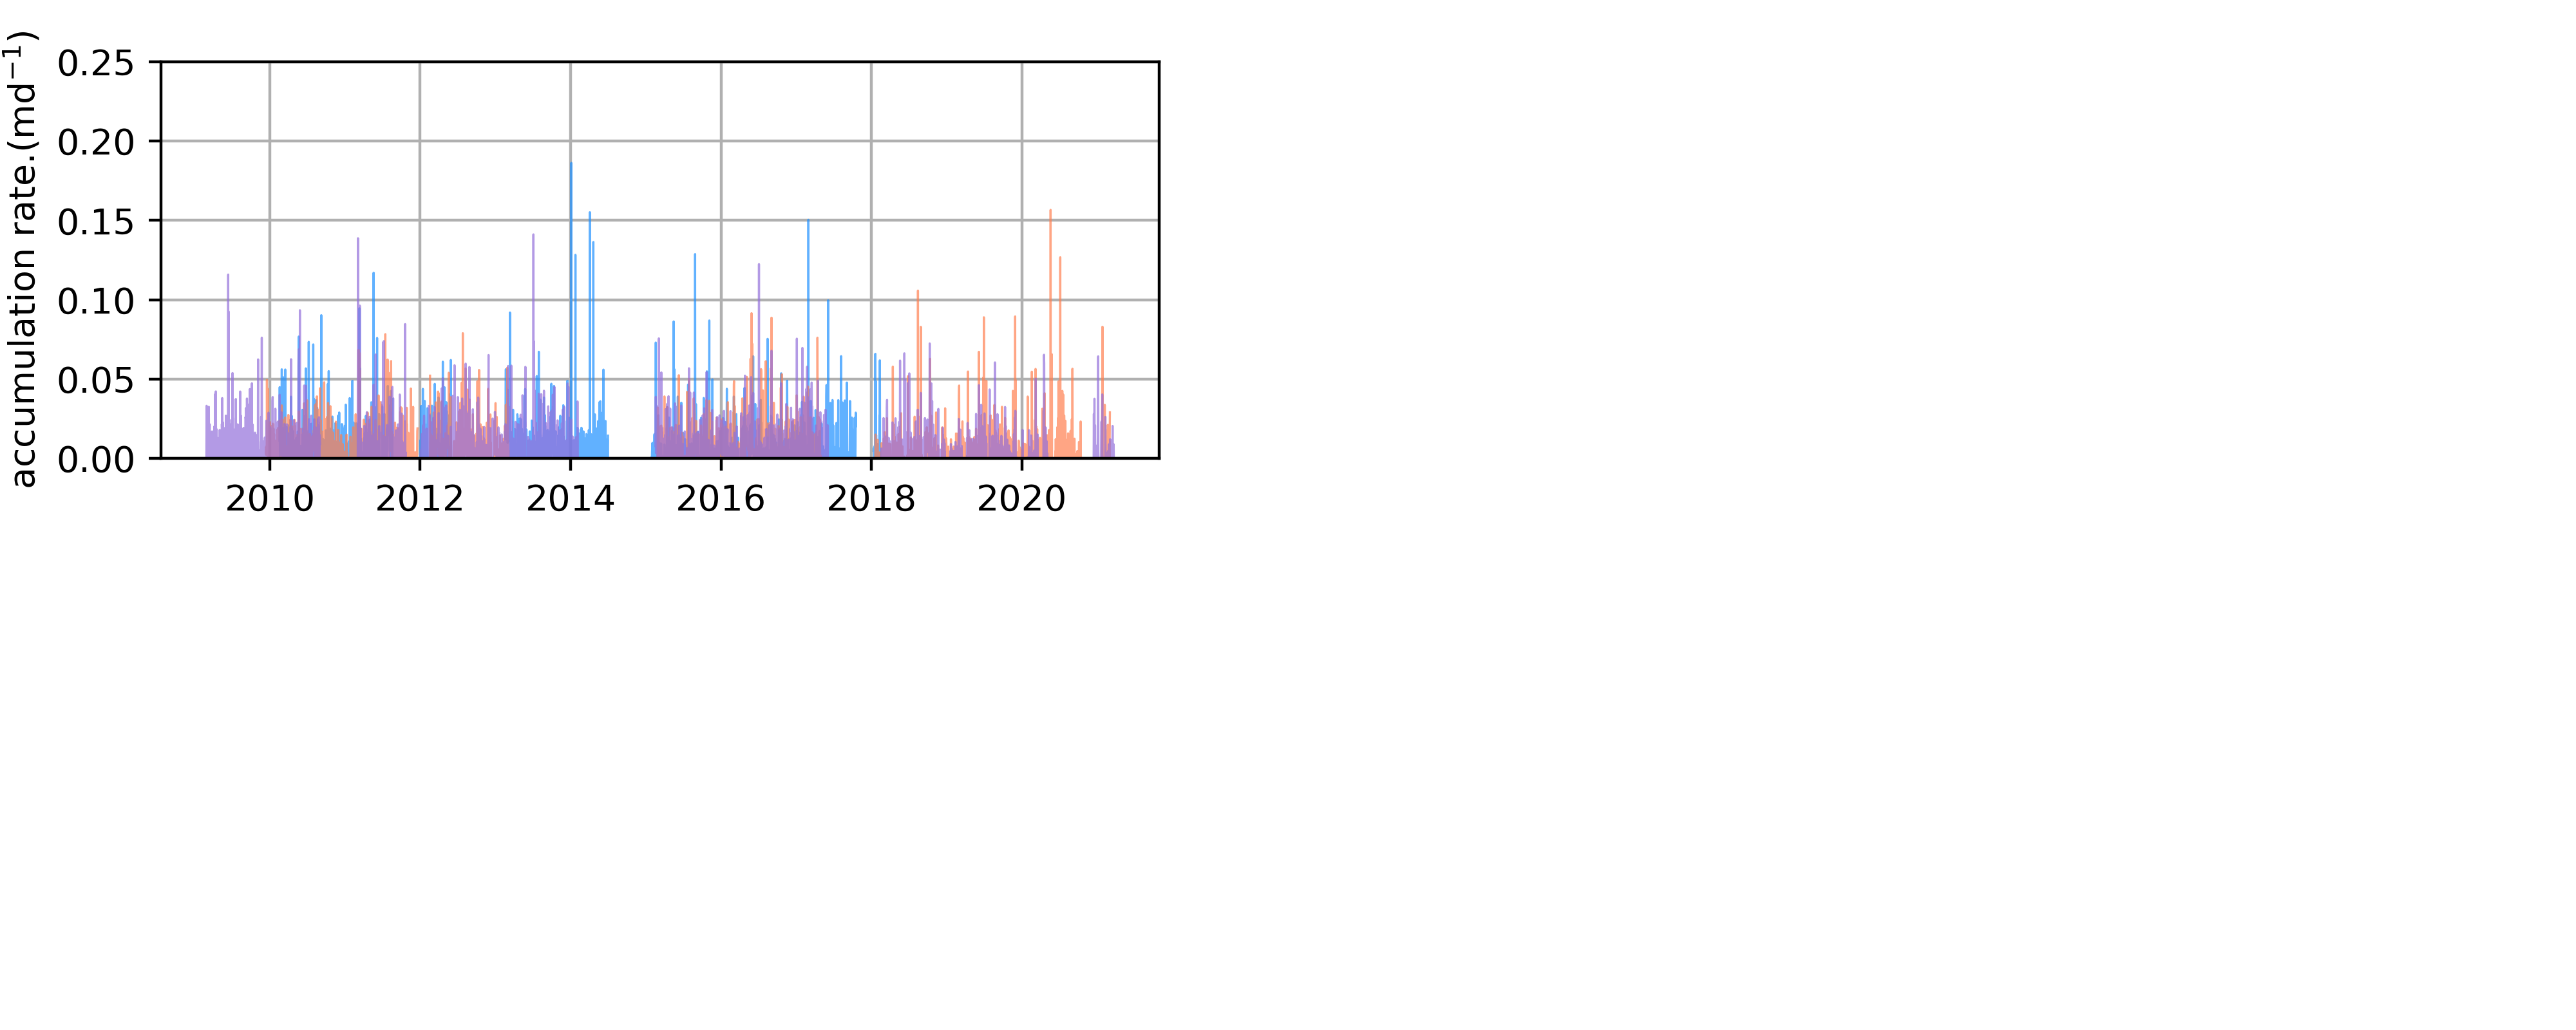

(0.0, 0.25)

In [447]:
fig,ax=plt.subplots(figsize=(5,2),dpi=200)
ax.plot(khlr_median['accumulation'],'-',linewidth=.6,markersize=2,markeredgewidth=0.0,color='dodgerblue',alpha=.7)
ax.plot(lthw_median['accumulation'],'-',linewidth=.6,markersize=2,markeredgewidth=0.0,color='coral',alpha=.7)
ax.plot(uthw_median['accumulation'],'-',linewidth=.6,markersize=2,markeredgewidth=0.0,color='mediumpurple',alpha=.7)
ax.set_ylabel(r'accumulation rate.(md$^{-1}$)')
ax.grid()
ax.set_ylim((0,.25))

In [125]:
i=3
RHdata=(uthw_median['mean'].to_numpy()[uthw_ind[i][0]:uthw_ind[i][1]])
n_steps=uthw_ind[i][1]-uthw_ind[i][0]
depth0 = 6.120-np.nanmax(RHdata)
acc0=np.diff(RHdata,axis=0)
acc0=np.append([0.],-1.0*acc0)
acc0[np.isnan(acc0)]=0.0
acc0[acc0<0]=0.0
D0=depth0/40.*np.ones(40, dtype=float)
rho0=np.arange(300,400,100./len(D0))
l=len(acc0)+len(rho0)+2
iterations=10000
outputs, misfits = monte_carlo_run(rho0,acc0,rho_new,eta,D0,RHdata,n_steps,n_iterates=iterations,regularization=1.0)#1000.0)
    
best = np.argmin(misfits[:, 0])
rho0best=outputs[:,best][:len(rho0)]
accbest=outputs[:,best][len(rho0):][:len(acc0)]
rho_newbest=outputs[:,best][len(rho0):][len(acc0):][0]
etabest=outputs[:,best][len(rho0):][len(acc0):][1]
    
uthw_record[uthw_ind[i][0]:uthw_ind[i][1]]=accbest


Run took 1042.3s


730401206343.5837
400.1687220951588


<IPython.core.display.Javascript object>


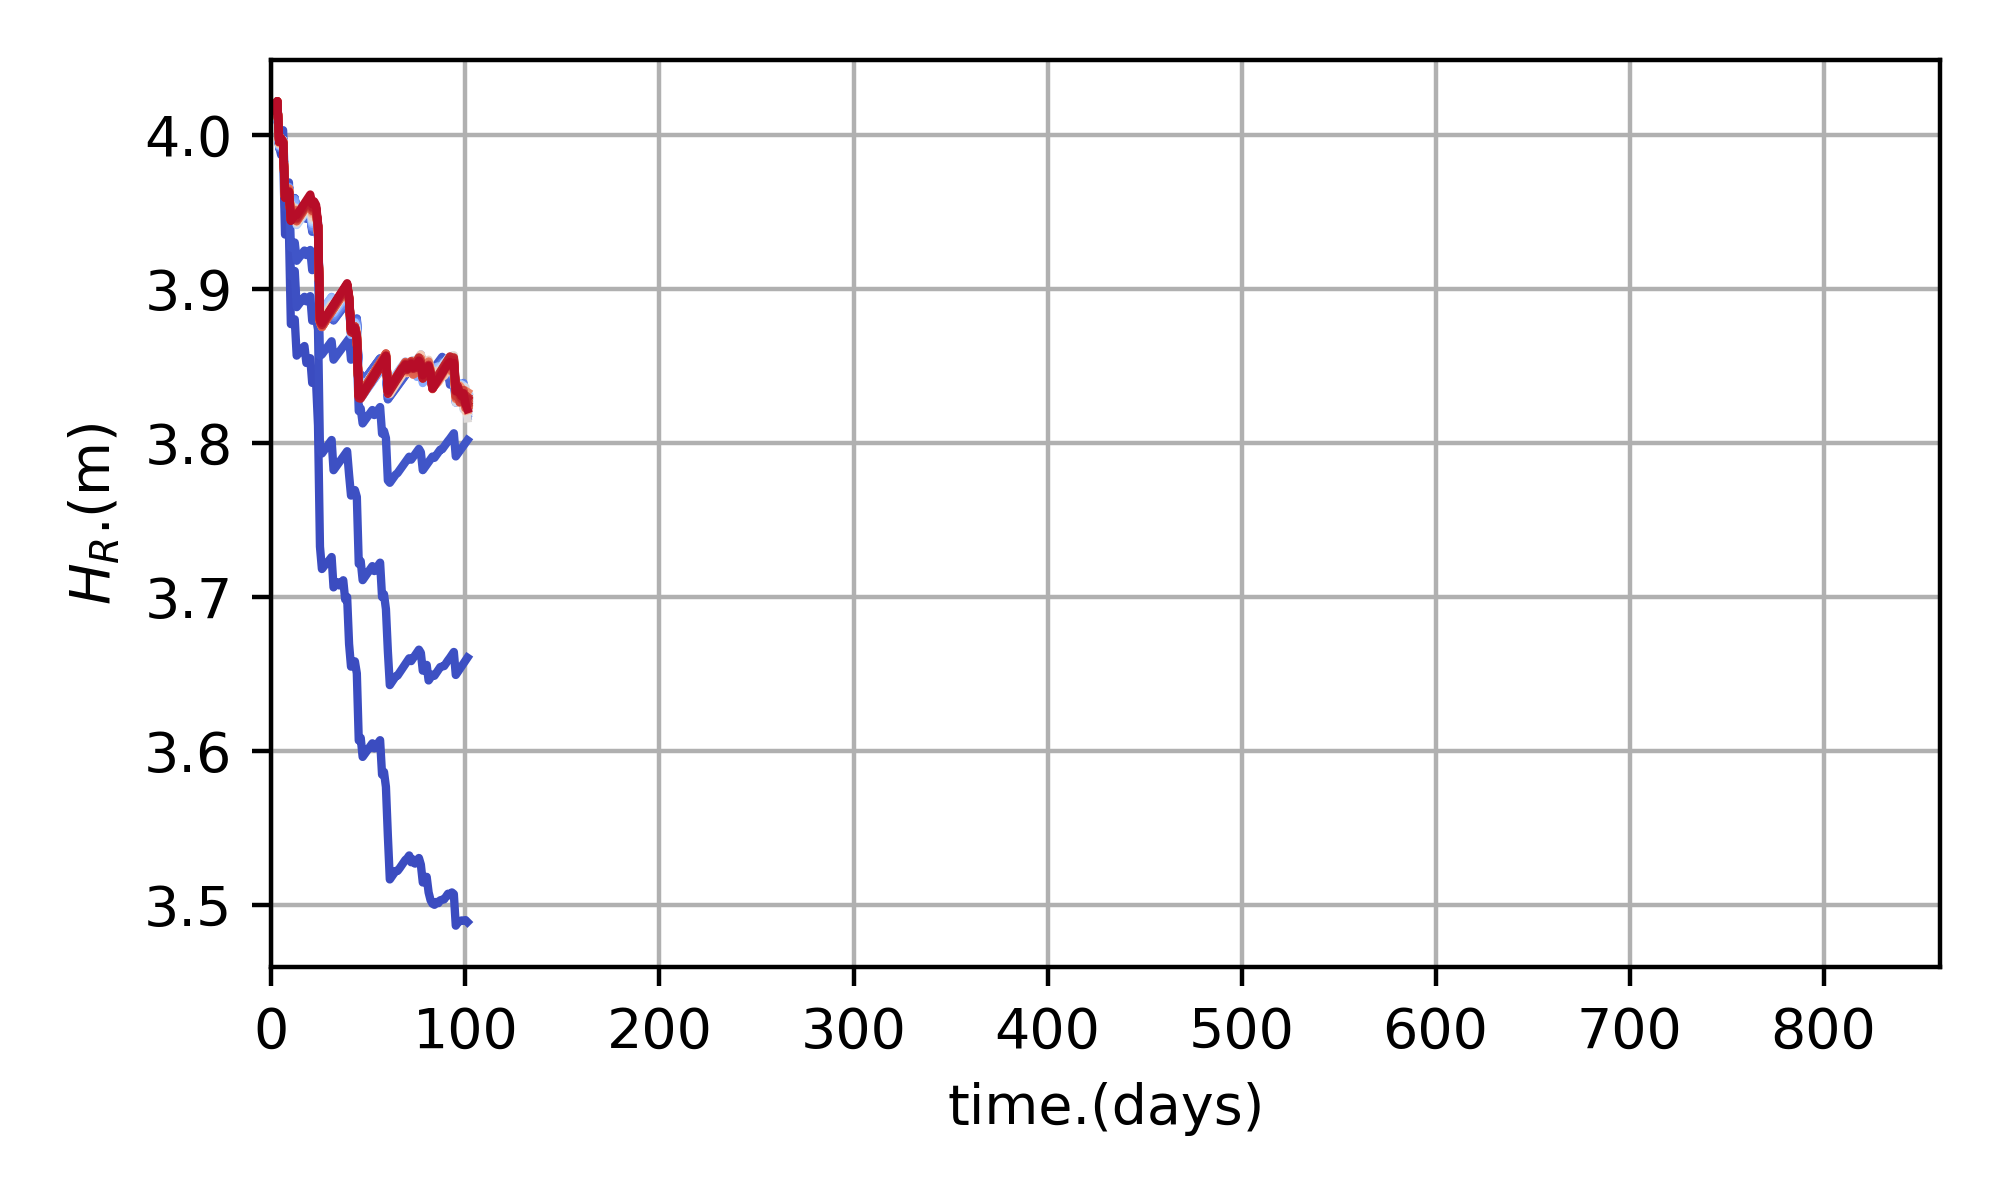

"\n# Plot it---it is linear as we expect\nplt.figure(figsize=(7, 4))\nplt.plot(rho0best, depth)\nplt.xlabel('density.(kg/m^3)')\nplt.ylabel( 'depth.(m)')\nplt.gca().invert_yaxis()\nplt.close(fig)\n\nfig, ax = plt.subplots()\nfor n in range(0,iterations-1,100):\n    ax.plot(outputs[:,n][len(rho0):][:len(acc0)],\n            color=colormap((n + 1) / (iterations-1)))\nax.set_xlabel('day of year')\nax.set_ylabel('accumulation rate.(m/d)')\n\nfig, ax = plt.subplots()\nplt.plot(np.arange(misfits.shape[0]), misfits[:, 0])\nax.xlim(0,860)\nax.set_xlabel('Iterate')\nax.set_ylabel('Cost')"

In [448]:
best = np.argmin(misfits[:, 0])
rho0best=outputs[:,best][:len(rho0)]
accbest=outputs[:,best][len(rho0):][:len(acc0)]
rho_newbest=outputs[:,best][len(rho0):][len(acc0):][0]
etabest=outputs[:,best][len(rho0):][len(acc0):][1]

print(etabest)
print(rho_newbest)

doy = np.arange(0,n_steps,1)
depth = np.cumsum(D0)

num_samples =20

colormap = plt.get_cmap('coolwarm')


#def model(layerthickness, acc_t, rho_o, total_time, rho_snow, eta0, n_tsteps=200):
nsamples = 20

fig2, ax2 = plt.subplots(figsize=(5,3),dpi=200)
for n in range(0,iterations-1,math.floor(iterations/100)):
    D=D0
    RH = model(D,outputs[:,n][len(rho0):][:len(acc0)], outputs[:,n][:len(rho0)],n_steps*86400,outputs[:,n][len(rho0):][len(acc0):][0],outputs[:,n][len(rho0):][len(acc0):][1],n_tsteps=n_steps)
    ax2.plot(RH,
            color=colormap((n + 1) / iterations))

RHbest=model(D,accbest, rho0best,n_steps*86400,rho_newbest,etabest,n_tsteps=n_steps)
ax2.plot(RHdata,'.',markersize=2,markeredgewidth=0.0, color='k')
#ax2.plot(RHbest , color='r')
ax2.set_xlabel('tim\
e.(days)')
ax2.set_ylabel(r'$H_R$.(m)')
ax2.set_xlim(0,860)
ax2.grid()
plt.tight_layout()
plt.close(fig)
"""
# Plot it---it is linear as we expect
plt.figure(figsize=(7, 4))
plt.plot(rho0best, depth)
plt.xlabel('density.(kg/m^3)')
plt.ylabel( 'depth.(m)')
plt.gca().invert_yaxis()
plt.close(fig)

fig, ax = plt.subplots()
for n in range(0,iterations-1,100):
    ax.plot(outputs[:,n][len(rho0):][:len(acc0)],
            color=colormap((n + 1) / (iterations-1)))
ax.set_xlabel('day of year')
ax.set_ylabel('accumulation rate.(m/d)')

fig, ax = plt.subplots()
plt.plot(np.arange(misfits.shape[0]), misfits[:, 0])
ax.xlim(0,860)
ax.set_xlabel('Iterate')
ax.set_ylabel('Cost')"""

<IPython.core.display.Javascript object>


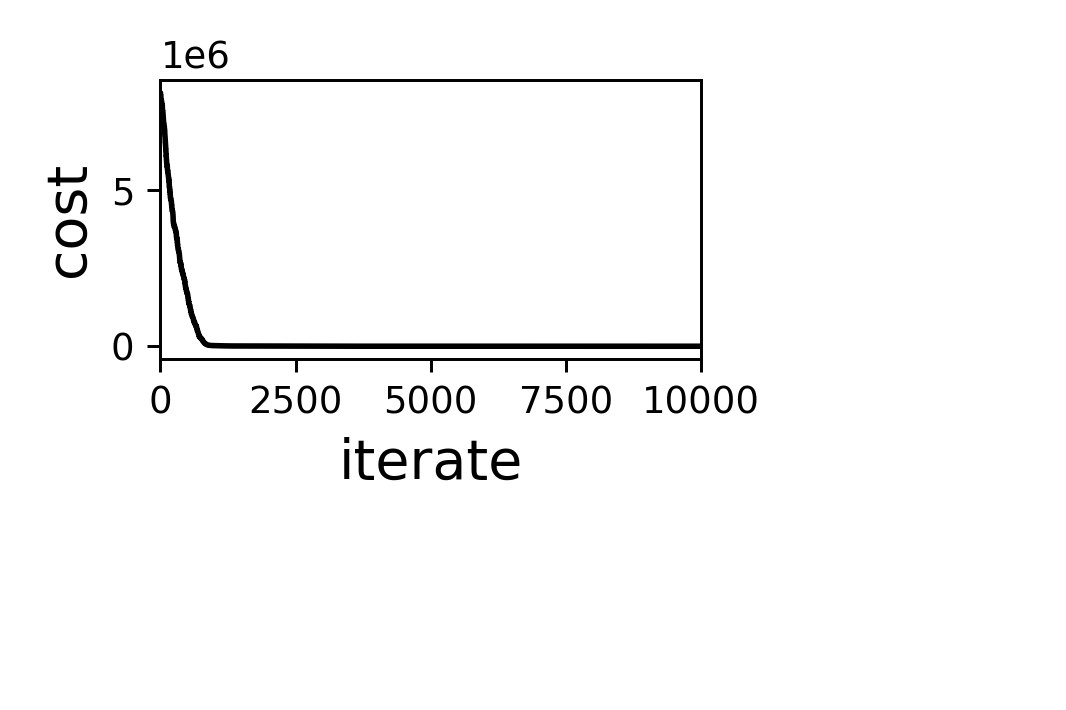

In [172]:
fig, ax = plt.subplots(figsize=(3,2),dpi=200)
plt.plot(np.arange(misfits[0].shape[0]), misfits[0][:, 0],color='k')
ax.set_xlabel('iterate',fontsize=15)
ax.set_ylabel('cost',fontsize=15)
ax.set_xlim(0,10000)
plt.tight_layout()


In [641]:
best1 = np.argmin(misfits[:, 0]).copy()
rho0best1=outputs[:,best][:len(rho0)].copy()
accbest1=outputs[:,best][len(rho0):][:len(acc0)].copy()
rho_newbest1=outputs[:,best][len(rho0):][len(acc0):][0].copy()
etabest1=outputs[:,best][len(rho0):][len(acc0):][1].copy()

In [656]:
best2 = np.argmin(misfits[:, 0]).copy()
rho0best2=outputs[:,best][:len(rho0)].copy()
accbest2=outputs[:,best][len(rho0):][:len(acc0)].copy()
rho_newbest2=outputs[:,best][len(rho0):][len(acc0):][0].copy()
etabest2=outputs[:,best][len(rho0):][len(acc0):][1].copy()

In [688]:
best3 = np.argmin(misfits[:, 0]).copy()
rho0best3=outputs[:,best][:len(rho0)].copy()
accbest3=outputs[:,best][len(rho0):][:len(acc0)].copy()
rho_newbest3=outputs[:,best][len(rho0):][len(acc0):][0].copy()
etabest3=outputs[:,best][len(rho0):][len(acc0):][1].copy()

In [745]:
best4 = np.argmin(misfits[:, 0]).copy()
rho0best4=outputs[:,best][:len(rho0)].copy()
accbest4=outputs[:,best][len(rho0):][:len(acc0)].copy()
rho_newbest4=outputs[:,best][len(rho0):][len(acc0):][0].copy()
etabest4=outputs[:,best][len(rho0):][len(acc0):][1].copy()

In [788]:
best5 = np.argmin(misfits[:, 0]).copy()
rho0best5=outputs[:,best][:len(rho0)].copy()
accbest5=outputs[:,best][len(rho0):][:len(acc0)].copy()
rho_newbest5=outputs[:,best][len(rho0):][len(acc0):][0].copy()
etabest5=outputs[:,best][len(rho0):][len(acc0):][1].copy()

In [800]:
a1 = np.empty((365+312))
a1[:] = np.nan
a2 = np.empty((300))
a2[:] = np.nan

In [801]:
accbestTS=np.concatenate([accbest1*rho_newbest1/1000.0,accbest2*rho_newbest2/1000.0,accbest3*rho_newbest3/1000.0,a1,accbest4*rho_newbest4/1000.0,a2,accbest5*rho_newbest5/1000.0],axis=0)
import datetime

base = datetime.datetime(2009, 12, 11)
TS = np.array([base + datetime.timedelta(days=i) for i in range(len(accbestTS))])


<IPython.core.display.Javascript object>


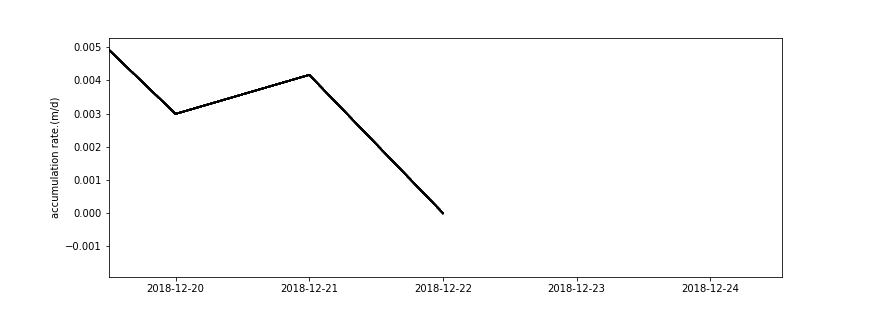

Text(0, 0.5, 'accumulation rate.(m/d)')

In [844]:
fig, ax = plt.subplots()
for n in range(0,iterations-1,100):
    ax.plot(TS,accbestTS,
            color=colormap((n + 1) / (iterations-1)))
ax.set_ylabel('accumulation rate.(m/d)')

In [814]:
import pandas as pd
import geopandas as gpd

In [818]:
df = pd.read_csv('/Users/andrewhoffman/Downloads/ASLMonthly.csv')

In [832]:
monthmeanlon=np.zeros((12))
for j in range(12):
    monthmeanlon[j]=np.mean(df['VarName5'][df['VarName2']==j+1])

In [833]:
month_accumTS=np.zeros((12))
for k in []:
    for j in range(12):
        ind[j] = [TS[i].month==j+1 for i in range(len(accbestTS))]
            month_accumTS[j]=np.nanmean(accbestTS[ind[j]])*365.0

In [874]:
years=np.empty((TS.shape[0]))
days=np.empty((TS.shape[0]))
months=np.empty((TS.shape[0]))

for i in range(TS.shape[0]):
    years[i]=TS[i].year
    months[i]=TS[i].month
    days[i]=TS[i].day

In [848]:
import h5py

In [880]:
hf = h5py.File('lthw2009121120181222.h5','w')

In [881]:
hf.create_dataset('accumulation',data=accbestTS)
hf.create_dataset('year',data=years)
hf.create_dataset('month',data=months)
hf.create_dataset('dat',data=days)



<HDF5 dataset "dat": shape (3299,), type "<f8">

In [3]:

best = np.argmin(misfits[:, 0])
rho0best=outputs[:,best][:len(rho0)]
accbest=outputs[:,best][len(rho0):][:len(acc0)]
rho_newbest=outputs[:,best][len(rho0):][len(acc0):][0]
etabest=outputs[:,best][len(rho0):][len(acc0):][1]

print(etabest)
print(rho_newbest)

doy = np.arange(0,n_steps,1)
depth = np.cumsum(D0)

num_samples =20

colormap = plt.get_cmap('coolwarm')


#def model(layerthickness, acc_t, rho_o, total_time, rho_snow, eta0, n_tsteps=200):
nsamples = 20

fig2, ax2 = plt.subplots(figsize=(5,3),dpi=200)
for n in range(0,iterations-1,math.floor(iterations/100)):
    D=D0
    RH = model(D,outputs[:,n][len(rho0):][:len(acc0)], outputs[:,n][:len(rho0)],n_steps*86400,outputs[:,n][len(rho0):][len(acc0):][0],outputs[:,n][len(rho0):][len(acc0):][1],n_tsteps=n_steps)
    ax2.plot(RH,
            color=colormap((n + 1) / iterations))

RHbest=model(D,accbest, rho0best,n_steps*86400,rho_newbest,etabest,n_tsteps=n_steps)
ax2.plot(RHdata,'.',markersize=2,markeredgewidth=0.0, color='k')
#ax2.plot(RHbest , color='r')
ax2.set_xlabel('time.(days)')
ax2.set_ylabel(r'$H_R$.(m)')
ax2.set_xlim(0,860)
ax2.grid()
plt.tight_layout()
plt.close(fig)


NameError: name 'np' is not defined